In [994]:
import numpy as np
import pandas as pd
import nltk

from nltk.tokenize import sent_tokenize 
from nltk.tokenize import word_tokenize 
from nltk.tokenize import regexp_tokenize 
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer 

from matplotlib import pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

from collections import Counter
import re
import pickle
from copy import deepcopy
from time import time

pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_columns', 500)

In [ ]:
# this is an extra function to clean text
from nltk.stem.snowball import SnowballStemmer
from pyspark.sql.functions import udf

# Create the function that performs the text conversion

sn = SnowballStemmer('english')

def clean_text(text, sn=sn):
 
    # Regular expression substitutions
    punc_re = re.compile('[%s]' % re.escape(string.punctuation + '£'))
    text = punc_re.sub(' ', ' '+text.lower()+' ') # Pad with spaces for easier stopword removal

    # Remove numbers
    num_re = re.compile('(\\d+)')
    text = num_re.sub(' ', text)
    
    # Remove alphanumerical words
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    text = alpha_num_re.sub(' ', text)
    
    # Stemming
    text = sn.stem(text)
    
    # Regex for multiple spaces
    spaces_re = re.compile('\s+')
    text = spaces_re.sub(' ', text.strip())

    return text

# Convert the function to a UDF
clean_text = udf(clean_text)

In [6]:
# read in dfs
tr = pd.read_csv('transcripts.csv')
ted = pd.read_csv('ted_main.csv')
print(tr.shape, ted.shape)

(2467, 2) (2550, 17)


In [7]:
# create a global df
df = pd.merge(tr, ted, on='url' )
print(df.shape)

(2467, 18)


In [8]:
# Convert documents column into a list that can be fed to a vectorizer
documents=df['transcript'].tolist()

In [9]:
len(documents)

2467

In [652]:
regex_words = ['00', '000', '0000', '000000004', '0000001', '000001', '00001', '000042', '0001', '0009', '000', '001', '0015', '003', '004', '004867', '005', '005545', '005634', '005961', '006', '007', '007080', '008106', '008309', '008494', '01', '0111', '02', '020', '024', '025', '03', '034', '035', '04', '040', '0400', '041', '047', '048', '05', '050', '05049', '051', '052', '06', '064', '07', '077', '08', '080', '09', '098', '0', '0', '10', '100', '1000', '1000', '1000', '100', '100', '101', '10165', '102', '103', '103', '104', '105', '106', '107', '107', '108', '109', '109', '10', '10', '10', '10', '10', '10', '10', '11', '110', '111', '112', '113', '114', '115', '117', '118', '119', '11', '11', '12', '120', '1200', '120', '121', '1214', '122', '1229', '123', '12345678', '124', '124', '125', '1252', '1258', '125', '126', '127', '128', '1280', '129', '1298', '12', '13', '130', '1300', '1300', '130', '1311', '1313', '132', '1323', '133', '1339', '134', '135', '136', '1368', '1369', '136', '137', '138', '139', '1390', '1391', '13', '14', '140', '1400', '1400', '140', '1415', '14159265358979', '1416', '1419', '141', '142', '143', '1434', '144', '145', '1450', '1450', '1455', '146', '147', '148', '1491', '1492', '1494', '1498', '14', '15', '150', '1500', '1500', '150', '151', '152', '1520', '153', '1534', '154', '1543', '155', '156', '1560', '1561', '1564', '157', '1574', '158', '1584', '1591', '15', '15', '15', '16', '160', '1600', '1600', '1607', '1609', '161', '162', '1620', '1621', '1623', '163', '1635', '164', '1642', '165', '1650', '1650', '1651', '1654', '1655', '1656', '166', '167', '1673', '1675', '1679', '168', '1680', '1688', '169', '16', '16', '16', '16', '16', '17', '170', '1700', '1700', '171', '1718', '172', '172', '173', '1731', '1736', '1738', '174', '1740', '1742', '175', '1750', '1750', '1751', '1759', '176', '1760', '1764', '177', '1770', '1771', '1772', '1775', '1776', '1777', '177', '178', '1780', '1781', '1784', '1785', '1787', '1788', '179', '1790', '1792', '1796', '1797', '17', '18', '180', '1800', '1800', '1801', '1802', '1803', '1809', '181', '1812', '1813', '1816', '1817', '1819', '182', '1820', '1824', '1827', '1829', '183', '1830', '1830', '1832', '1833', '1834', '1835', '1837', '1838', '184', '1840', '1840', '1841', '1842', '1844', '1847', '1848', '1849', '185', '1850', '1850', '1851', '1852', '1853', '1854', '1855', '1856', '1858', '1859', '186', '1860', '1860', '1862', '1863', '1865', '1866', '1867', '1868', '1869', '186', '187', '1870', '1870', '1871', '1872', '1874', '1875', '1876', '1877', '1878', '1879', '188', '1880', '1880', '1881', '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889', '189', '1890', '1890', '1891', '1894', '1895', '1896', '1897', '1898', '1899', '18', '19', '190', '1900', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '191', '1910', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '192', '1920', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '194', '1940', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '195', '1950', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '196', '1960', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '197', '1970', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '198', '1980', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '199', '1990', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '19', '1', '1', '1', '1', '1', '1', '20', '200', '2000', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '200', '201', '2010', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2030', '2033', '2034', '2035', '2036', '204', '2040', '2040', '2041', '2042', '2045', '2048', '2049', '205', '2050', '2054', '206', '2060', '2065', '207', '2070', '2075', '208', '209', '20', '20', '20', '20', '21', '210', '2100', '2106', '211', '212', '213', '2133', '214', '215', '2150', '216', '217', '218', '2186', '219', '2191', '21', '22', '220', '221', '221', '223', '225', '226', '227', '228', '22', '23', '230', '232', '233', '234', '235', '236', '238', '23', '23', '24', '240', '244', '246', '247', '248', '249', '24972', '24', '25', '250', '251', '252', '253', '254', '256', '257', '25871', '259', '2592', '25', '26', '260', '262', '265', '2657', '266', '267', '26', '27', '270', '271', '275', '276', '27', '28', '280', '284', '285', '28841', '28', '29', '290', '291', '292', '295', '298', '299', '29', '2', '2', '2', '2', '2', '2', '2', '30', '300', '3000', '303', '305', '306', '307', '30', '30', '30', '30', '30', '31', '310', '311', '312', '314', '315', '316', '317', '318', '31', '32', '320', '321', '3220', '323', '324', '325', '326', '327', '328', '33', '330', '331', '333', '334', '335', '338', '339', '34', '340', '343', '345', '348', '3481', '34', '35', '350', '3500', '351', '352', '353', '35', '35', '35', '36', '360', '3600', '360', '360', '365', '368', '37', '370', '371', '374', '375', '376', '37', '38', '380', '382', '384', '3846264338327950', '385', '3876', '38', '38', '39', '390', '391', '3928', '39', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '40', '400', '4000', '400', '400', '401', '403', '40307', '404', '405', '407', '408', '40', '40', '40', '41', '410', '411', '413', '414', '417', '42', '420', '424', '425', '426', '427', '428', '42', '43', '430', '432', '433', '436', '438', '439', '44', '440', '440', '442', '445', '448', '44875', '44', '45', '450', '452', '457', '459', '45', '46', '460', '4629', '463', '465', '466', '46645', '46664', '468', '46', '47', '470', '473', '474', '475', '476', '47', '47', '48', '480', '481', '486', '489', '49', '492', '498', '49', '49', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '50', '500', '500', '500', '501', '503', '509', '50', '50', '50', '50', '50', '51', '512', '513', '515', '517', '52', '525', '529', '53', '530', '530', '531', '533', '535', '536', '539', '53', '53', '54', '540', '544', '547', '54', '55', '550', '553', '554', '555', '556', '557', '558', '559', '55', '56', '5624', '564', '5657', '566', '56', '57', '571', '577', '57', '58', '580', '581', '59', '594', '599', '5', '5', '5', '5', '5', '60', '600', '607', '609', '60', '60', '60', '61', '610', '611', '612', '618', '61', '62', '620', '622', '6234', '625', '62', '63', '630', '64', '640', '648', '65', '650', '651', '652', '655', '657', '659', '66', '660', '662', '664', '665', '666', '667', '66', '67', '670', '677', '678', '68', '680', '68245837', '683', '687', '69', '690', '696', '698', '6', '6', '6', '6', '6', '6', '70', '700', '7000', '7003', '700', '701', '70112', '70124', '702', '707', '70', '70', '71', '711', '714', '716', '719', '72', '720', '722', '724', '725', '727', '729', '73', '730', '733', '737', '74', '740', '746', '747', '747', '748', '75', '750', '753', '757', '758', '759', '75', '76', '760', '76', '77', '770', '774', '776', '777', '77', '78', '780', '782', '785', '787', '7892', '78', '78', '79', '790', '7', '7', '80', '800', '800', '802', '804', '805', '80', '80', '81', '82', '822', '825', '826', '828', '83', '830', '831', '838', '84', '841', '844', '8462852', '849', '84', '85', '850', '855', '8567', '85871', '85', '86', '860', '862', '863', '864', '8649', '86', '87', '88', '880', '883', '885', '886', '89', '890', '898', '8', '8', '8', '8', '90', '900', '9000', '90', '90', '91', '911', '912', '915', '92', '920', '92121', '928', '93', '930', '931', '94', '945', '95', '950', '9500', '952', '9527', '956', '95', '96', '960', '961', '962', '967', '97', '971', '974', '979', '98', '982', '984', '987', '99', '996', '997', '999', '9997', '99999', '999999', '9', '9', '9', '______', '________', '1', '10', '12', '320', '380', '4', '58', '92', '32', '4', '4', 'ã', 'ñ', 'ć', 'é', 'é', 'é', 'ó', 'á', '4', '28', 'à', 'í', 'ê', 'ê', 'é', 'ä', 'á', '1', 'çã', 'š', '1', '12', '15', '2', '612', '7', '92', 'á', 'é', 'ó', 'ó', '16', '8', 'á', 'í', 'é', 'ā', 'è', 'ø', 'é', 'è', 'á', 'ñ', 'í', 'ó', '1', '2', '4', 'é', 'ë', 'ăť', 'û', 'é', 'ê', 'ö', '02', '3', '4', '40', '74', 'ó', 'é', 'é', 'ó', 'í', 'ç', 'ç', 'é', '9', '1', '5', '4', '4', '0', 'á', 'â', '3', 'é', 'é', 'é', 'é', '1', '2', '2', '2', 'ó', '15', '21', 'ö', 'è', 'á', 'ç', 'á', 'è', 'è', 'é', 'ó', 'ó', 'ô', '1', '2', 'é', '8', 'é', '1', 'é', 'ä', 'á', 'é', 'é', 'é', 'é', 'é', 'é', 'é', '3', '4', '8', '85', '3', 'ö', 'é', 'æ', 'é', '1', 'é', 'é', 'è', '1', 'é', 'é', '1', '15', '18', '22', 'í', 'á', 'é', 'ó', '2', 'ç', 'ç', 'é', 'è', 'â', 'ê', 'ü', '1', '2', '20', '2', '3', '4', '5', '7', '8', 'é', 'æ', 'ó', 'í', 'í', '9', 'ü', 'ð', 'í', 'ã', 'é', 'é', 'í', 'ñ', 'í', 'í', 'ã', 'ö', 'ó', 'ö', '1', '20', '2', '2', '2', '30', '3', '5', 'ø', 'ï', '2', 'è', 'é', '5', 'ä', 'ä', 'é', 'í', 'ö', 'ì', 'é', '2', '57', 'í', 'é', 'ã', 'ë', '1', 'ó', 'á', 'á', 'é', 'á', 'ó', 'ó', '1', '2', 'ñ', '²', 'ō', 'é', 'ü', 'è', 'é', 'í', 'ö', 'ö', 'ā', '1', '2', '22', '41', 'é', 'ó', '2', 'á', 'é', '29', 'á', 'ā', '25', 'è', 'á', 'á', 'é', 'é', 'é', 'é', 'ā', 'ā', 'ẹ', '13', '16', '25', '4', '400', 'ñ', 'é', 'ú', 'í', 'í', 'ç', 'í', '001', 'é', 'é', 'ā', '2', '²', '109', 'í', '10', '370', '6', 'á', 'ć', 'ø', 'é', '2', '3', '3', '3', 'é', '3', 'á', 'á', 'é', 'é', 'é', 'é', 'í', 'ò', 'ó', 'ö', 'ö', 'ě', '95', 'é', '2', 'á', 'ï', 'ï', 'ï', 'ï', 'é', 'é', 'á', 'ö', 'ñ', '2', '3', '2', 'é', '2', '600', 'è', 'é', 'ê', '222', 'á', 'í', 'é', 'í', '1', '25', '2', '4', '53', 'á', 'é', 'é', 'í', 'í', '254', 'á', 'ó', 'é', 'ñ', 'ñ', 'ù', 'è', '10', '2', '2', 'â', 'é', 'é', '2', 'é', 'é', 'í', '1', '10', '3', 'é', 'á', 'é', 'é', 'é', '2', '2', 'ù', 'ù', 'ó', '2', '2', 'ä', 'é', 'ó', 'í', 'í', 'ô', '7', '8', 'é', 'é', 'é', 'é', 'í', 'í', 'ö', 'ū', '2', '600', '7', 'é', 'ö', 'ñ', 'ü', '1000', '2', '1978', 'é', 'ø', '2', '_', '71', '1', 'ö', 'á', 'á', 'ã', 'è', 'é', 'í', 'í', 'í', 'ó', 'ó', 'ø', 'ü', 'ī', 'τ', '1', '12', '2', '20', '3', '85', 'ā', 'ï', '2003', '2006', '2008', '2009', '2015', '2017', 'í', 'é', '2', 'ö', 'á', 'é', 'é', '53', 'é', 'ø', 'è', '20', 'ó', 'ô', '2', '235', '238', 'á', 'ø', '12', 'é', 'á', 'ó', 'í', 'é', 'à', 'á', 'é', '1', '3', '25', 'ä', '77', 'é', '174', 'è', '2', 'ù', 'ī', '9', '80', '81', '143', 'é', 'º', 'á', 'á', 'á', 'å', 'ç', 'ç', 'è', 'é', 'é', 'é', 'é', 'é', 'é', 'é', 'ê', 'í', 'ñ', 'ö', 'ö', 'ü', 'ü', 'ā', 'č', 'ō', 'ʾ', 'ʾ', 'ʾ', 'อย', 'อย', 'อร', '送你葱']

In [653]:
# extend this list in case I need to expand my stopwords (or have two much time on my hands and wanna be a perfectionist :|)
stop = stopwords.words('english')
stop += ['oh', 'yeah', 'wo', 'somebody', 'ted', 'whatever',  'short', 'everybody', 'easy',  'either', 'least', 'third', 'wrote', '00', '000', '0000', '000000004', '0000001', '000001', '00001', '000042', '0001', '0009', '000', '001', '0015', '003', '004', '004867', '005', '005545', '005634', '005961', '006', '007', '007080', '008106', '008309', '008494', '01', '0111', '02', '020', '024', '025', '03', '034', '035', '04', '040', '0400', '041', '047', '048', '05', '050', '05049', '051', '052', '06', '064', '07', '077', '08', '080', '09', '098', '0', '0', '10', '100', '1000', '1000', '1000', '100', '100', '101', '10165', '102', '103', '103', '104', '105', '106', '107', '107', '108', '109', '109', '10', '10', '10', '10', '10', '10', '10', '11', '110', '111', '112', '113', '114', '115', '117', '118', '119', '11', '11', '12', '120', '1200', '120', '121', '1214', '122', '1229', '123', '12345678', '124', '124', '125', '1252', '1258', '125', '126', '127', '128', '1280', '129', '1298', '12', '13', '130', '1300', '1300', '130', '1311', '1313', '132', '1323', '133', '1339', '134', '135', '136', '1368', '1369', '136', '137', '138', '139', '1390', '1391', '13', '14', '140', '1400', '1400', '140', '1415', '14159265358979', '1416', '1419', '141', '142', '143', '1434', '144', '145', '1450', '1450', '1455', '146', '147', '148', '1491', '1492', '1494', '1498', '14', '15', '150', '1500', '1500', '150', '151', '152', '1520', '153', '1534', '154', '1543', '155', '156', '1560', '1561', '1564', '157', '1574', '158', '1584', '1591', '15', '15', '15', '16', '160', '1600', '1600', '1607', '1609', '161', '162', '1620', '1621', '1623', '163', '1635', '164', '1642', '165', '1650', '1650', '1651', '1654', '1655', '1656', '166', '167', '1673', '1675', '1679', '168', '1680', '1688', '169', '16', '16', '16', '16', '16', '17', '170', '1700', '1700', '171', '1718', '172', '172', '173', '1731', '1736', '1738', '174', '1740', '1742', '175', '1750', '1750', '1751', '1759', '176', '1760', '1764', '177', '1770', '1771', '1772', '1775', '1776', '1777', '177', '178', '1780', '1781', '1784', '1785', '1787', '1788', '179', '1790', '1792', '1796', '1797', '17', '18', '180', '1800', '1800', '1801', '1802', '1803', '1809', '181', '1812', '1813', '1816', '1817', '1819', '182', '1820', '1824', '1827', '1829', '183', '1830', '1830', '1832', '1833', '1834', '1835', '1837', '1838', '184', '1840', '1840', '1841', '1842', '1844', '1847', '1848', '1849', '185', '1850', '1850', '1851', '1852', '1853', '1854', '1855', '1856', '1858', '1859', '186', '1860', '1860', '1862', '1863', '1865', '1866', '1867', '1868', '1869', '186', '187', '1870', '1870', '1871', '1872', '1874', '1875', '1876', '1877', '1878', '1879', '188', '1880', '1880', '1881', '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889', '189', '1890', '1890', '1891', '1894', '1895', '1896', '1897', '1898', '1899', '18', '19', '190', '1900', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '191', '1910', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '192', '1920', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '194', '1940', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '195', '1950', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '196', '1960', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '197', '1970', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '198', '1980', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '199', '1990', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '19', '1', '1', '1', '1', '1', '1', '20', '200', '2000', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '200', '201', '2010', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2030', '2033', '2034', '2035', '2036', '204', '2040', '2040', '2041', '2042', '2045', '2048', '2049', '205', '2050', '2054', '206', '2060', '2065', '207', '2070', '2075', '208', '209', '20', '20', '20', '20', '21', '210', '2100', '2106', '211', '212', '213', '2133', '214', '215', '2150', '216', '217', '218', '2186', '219', '2191', '21', '22', '220', '221', '221', '223', '225', '226', '227', '228', '22', '23', '230', '232', '233', '234', '235', '236', '238', '23', '23', '24', '240', '244', '246', '247', '248', '249', '24972', '24', '25', '250', '251', '252', '253', '254', '256', '257', '25871', '259', '2592', '25', '26', '260', '262', '265', '2657', '266', '267', '26', '27', '270', '271', '275', '276', '27', '28', '280', '284', '285', '28841', '28', '29', '290', '291', '292', '295', '298', '299', '29', '2', '2', '2', '2', '2', '2', '2', '30', '300', '3000', '303', '305', '306', '307', '30', '30', '30', '30', '30', '31', '310', '311', '312', '314', '315', '316', '317', '318', '31', '32', '320', '321', '3220', '323', '324', '325', '326', '327', '328', '33', '330', '331', '333', '334', '335', '338', '339', '34', '340', '343', '345', '348', '3481', '34', '35', '350', '3500', '351', '352', '353', '35', '35', '35', '36', '360', '3600', '360', '360', '365', '368', '37', '370', '371', '374', '375', '376', '37', '38', '380', '382', '384', '3846264338327950', '385', '3876', '38', '38', '39', '390', '391', '3928', '39', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '40', '400', '4000', '400', '400', '401', '403', '40307', '404', '405', '407', '408', '40', '40', '40', '41', '410', '411', '413', '414', '417', '42', '420', '424', '425', '426', '427', '428', '42', '43', '430', '432', '433', '436', '438', '439', '44', '440', '440', '442', '445', '448', '44875', '44', '45', '450', '452', '457', '459', '45', '46', '460', '4629', '463', '465', '466', '46645', '46664', '468', '46', '47', '470', '473', '474', '475', '476', '47', '47', '48', '480', '481', '486', '489', '49', '492', '498', '49', '49', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '50', '500', '500', '500', '501', '503', '509', '50', '50', '50', '50', '50', '51', '512', '513', '515', '517', '52', '525', '529', '53', '530', '530', '531', '533', '535', '536', '539', '53', '53', '54', '540', '544', '547', '54', '55', '550', '553', '554', '555', '556', '557', '558', '559', '55', '56', '5624', '564', '5657', '566', '56', '57', '571', '577', '57', '58', '580', '581', '59', '594', '599', '5', '5', '5', '5', '5', '60', '600', '607', '609', '60', '60', '60', '61', '610', '611', '612', '618', '61', '62', '620', '622', '6234', '625', '62', '63', '630', '64', '640', '648', '65', '650', '651', '652', '655', '657', '659', '66', '660', '662', '664', '665', '666', '667', '66', '67', '670', '677', '678', '68', '680', '68245837', '683', '687', '69', '690', '696', '698', '6', '6', '6', '6', '6', '6', '70', '700', '7000', '7003', '700', '701', '70112', '70124', '702', '707', '70', '70', '71', '711', '714', '716', '719', '72', '720', '722', '724', '725', '727', '729', '73', '730', '733', '737', '74', '740', '746', '747', '747', '748', '75', '750', '753', '757', '758', '759', '75', '76', '760', '76', '77', '770', '774', '776', '777', '77', '78', '780', '782', '785', '787', '7892', '78', '78', '79', '790', '7', '7', '80', '800', '800', '802', '804', '805', '80', '80', '81', '82', '822', '825', '826', '828', '83', '830', '831', '838', '84', '841', '844', '8462852', '849', '84', '85', '850', '855', '8567', '85871', '85', '86', '860', '862', '863', '864', '8649', '86', '87', '88', '880', '883', '885', '886', '89', '890', '898', '8', '8', '8', '8', '90', '900', '9000', '90', '90', '91', '911', '912', '915', '92', '920', '92121', '928', '93', '930', '931', '94', '945', '95', '950', '9500', '952', '9527', '956', '95', '96', '960', '961', '962', '967', '97', '971', '974', '979', '98', '982', '984', '987', '99', '996', '997', '999', '9997', '99999', '999999', '9', '9', '9', '______', '________', '1', '10', '12', '320', '380', '4', '58', '92', '32', '4', '4', 'ã', 'ñ', 'ć', 'é', 'é', 'é', 'ó', 'á', '4', '28', 'à', 'í', 'ê', 'ê', 'é', 'ä', 'á', '1', 'çã', 'š', '1', '12', '15', '2', '612', '7', '92', 'á', 'é', 'ó', 'ó', '16', '8', 'á', 'í', 'é', 'ā', 'è', 'ø', 'é', 'è', 'á', 'ñ', 'í', 'ó', '1', '2', '4', 'é', 'ë', 'ăť', 'û', 'é', 'ê', 'ö', '02', '3', '4', '40', '74', 'ó', 'é', 'é', 'ó', 'í', 'ç', 'ç', 'é', '9', '1', '5', '4', '4', '0', 'á', 'â', '3', 'é', 'é', 'é', 'é', '1', '2', '2', '2', 'ó', '15', '21', 'ö', 'è', 'á', 'ç', 'á', 'è', 'è', 'é', 'ó', 'ó', 'ô', '1', '2', 'é', '8', 'é', '1', 'é', 'ä', 'á', 'é', 'é', 'é', 'é', 'é', 'é', 'é', '3', '4', '8', '85', '3', 'ö', 'é', 'æ', 'é', '1', 'é', 'é', 'è', '1', 'é', 'é', '1', '15', '18', '22', 'í', 'á', 'é', 'ó', '2', 'ç', 'ç', 'é', 'è', 'â', 'ê', 'ü', '1', '2', '20', '2', '3', '4', '5', '7', '8', 'é', 'æ', 'ó', 'í', 'í', '9', 'ü', 'ð', 'í', 'ã', 'é', 'é', 'í', 'ñ', 'í', 'í', 'ã', 'ö', 'ó', 'ö', '1', '20', '2', '2', '2', '30', '3', '5', 'ø', 'ï', '2', 'è', 'é', '5', 'ä', 'ä', 'é', 'í', 'ö', 'ì', 'é', '2', '57', 'í', 'é', 'ã', 'ë', '1', 'ó', 'á', 'á', 'é', 'á', 'ó', 'ó', '1', '2', 'ñ', '²', 'ō', 'é', 'ü', 'è', 'é', 'í', 'ö', 'ö', 'ā', '1', '2', '22', '41', 'é', 'ó', '2', 'á', 'é', '29', 'á', 'ā', '25', 'è', 'á', 'á', 'é', 'é', 'é', 'é', 'ā', 'ā', 'ẹ', '13', '16', '25', '4', '400', 'ñ', 'é', 'ú', 'í', 'í', 'ç', 'í', '001', 'é', 'é', 'ā', '2', '²', '109', 'í', '10', '370', '6', 'á', 'ć', 'ø', 'é', '2', '3', '3', '3', 'é', '3', 'á', 'á', 'é', 'é', 'é', 'é', 'í', 'ò', 'ó', 'ö', 'ö', 'ě', '95', 'é', '2', 'á', 'ï', 'ï', 'ï', 'ï', 'é', 'é', 'á', 'ö', 'ñ', '2', '3', '2', 'é', '2', '600', 'è', 'é', 'ê', '222', 'á', 'í', 'é', 'í', '1', '25', '2', '4', '53', 'á', 'é', 'é', 'í', 'í', '254', 'á', 'ó', 'é', 'ñ', 'ñ', 'ù', 'è', '10', '2', '2', 'â', 'é', 'é', '2', 'é', 'é', 'í', '1', '10', '3', 'é', 'á', 'é', 'é', 'é', '2', '2', 'ù', 'ù', 'ó', '2', '2', 'ä', 'é', 'ó', 'í', 'í', 'ô', '7', '8', 'é', 'é', 'é', 'é', 'í', 'í', 'ö', 'ū', '2', '600', '7', 'é', 'ö', 'ñ', 'ü', '1000', '2', '1978', 'é', 'ø', '2', '_', '71', '1', 'ö', 'á', 'á', 'ã', 'è', 'é', 'í', 'í', 'í', 'ó', 'ó', 'ø', 'ü', 'ī', 'τ', '1', '12', '2', '20', '3', '85', 'ā', 'ï', '2003', '2006', '2008', '2009', '2015', '2017', 'í', 'é', '2', 'ö', 'á', 'é', 'é', '53', 'é', 'ø', 'è', '20', 'ó', 'ô', '2', '235', '238', 'á', 'ø', '12', 'é', 'á', 'ó', 'í', 'é', 'à', 'á', 'é', '1', '3', '25', 'ä', '77', 'é', '174', 'è', '2', 'ù', 'ī', '9', '80', '81', '143', 'é', 'º', 'á', 'á', 'á', 'å', 'ç', 'ç', 'è', 'é', 'é', 'é', 'é', 'é', 'é', 'é', 'ê', 'í', 'ñ', 'ö', 'ö', 'ü', 'ü', 'ā', 'č', 'ō', 'ʾ', 'ʾ', 'ʾ', 'อย', 'อย', 'อร', '送你葱']
stop = list(set(stop))
print(len(stop))

1157


### Let's lemmatize my documents

In [10]:
#from nltk.stem.wordnet import WordNetLemmatizer 
lem = WordNetLemmatizer()
#from nltk.stem.porter import PorterStemmer 
stem = PorterStemmer()

In [11]:
# this will return a documents_lem list of documents with lemmatized words
documents_lem = [] # global list of all documents that have been lemmatized
for doc in documents: # iterate through each of existing documents
    doc_lem=[]
    for word in TextBlob(doc).words: 
        doc_lem.append(lem.lemmatize(word)) # lemmatize each word and append to a list
    doc = ' '.join(doc_lem) # join the list into a string
    documents_lem.append(doc) #append to the final list fo documents


In [12]:
documents[0][:100]

"Good morning. How are you?(Laughter)It's been great, hasn't it? I've been blown away by the whole th"

In [13]:
documents_lem[0][:100]

"Good morning How are you Laughter It 's been great ha n't it I 've been blown away by the whole thin"

In [32]:
# append lemmatized docs to main df 
dl=pd.DataFrame(documents_lem)
df = pd.merge(df, dl, left_index=True, right_index=True)
df = df.rename(columns={0: 'transcript_lem'})

In [37]:
# radomly check rows to make sure merge has been correct
df[['transcript','transcript_lem']].sample(10)

transcript  \
795   Alisa Volkman: So this is where our story begi...   
1219  Frugal Digital is essentially a small research...   
387   I was raised in Seoul, Korea, and moved to New...   
1623  Chris Anderson: We had Edward Snowden here a c...   
783   So I'm going to talk about work; specifically,...   
462   I have had the distinct pleasure of living ins...   
1618  ["Rebecca Newberger Goldstein"] ["Steven Pinke...   
1209  I study the future of crime and terrorism, and...   
707   I am a marine toxicologist, and I've been very...   
1835  I grew up with my identical twin, who was an i...   

                                         transcript_lem  
795   Alisa Volkman So this is where our story begin...  
1219  Frugal Digital is essentially a small research...  
387   I wa raised in Seoul Korea and moved to New Yo...  
1623  Chris Anderson We had Edward Snowden here a co...  
783   So I 'm going to talk about work specifically ...  
462   I have had the distinct pleasure of living ins...  
1618  Rebecca Newberger Goldstein Steven Pinker The ...  
1209  I study the future of crime and terrorism and ...  
707   I am a marine toxicologist and I 've been very...  
1835  I grew up with my identical twin who wa an inc...

In [166]:
# print out first transcript
#tr.transcript[0]

'Good morning. How are you?(Laughter)It\'s been great, hasn\'t it? I\'ve been blown away by the whole thing. In fact, I\'m leaving.(Laughter)There have been three themes running through the conference which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we\'ve had and in all of the people here. Just the variety of it and the range of it. The second is that it\'s put us in a place where we have no idea what\'s going to happen, in terms of the future. No idea how this may play out.I have an interest in education. Actually, what I find is everybody has an interest in education. Don\'t you? I find this very interesting. If you\'re at a dinner party, and you say you work in education — Actually, you\'re not often at dinner parties, frankly.(Laughter)If you work in education, you\'re not asked.(Laughter)And you\'re never asked back, curiously. That\'s strange to me. But if you are, and you say to somebody, you

In [ ]:
# print out first transcript  that is lemmed
#tr.transcript[0].split('(Laughter)')

### create bag of words:

**TF-IDF** A word can be important in a document if, 
- it occurs a lot in the document
- while rarely in other documents in the corpus. 
Term Frequency measures how often the word appears in a given document, while Inverse document frequency measures how rare the word is in a corpus. 


**Vectorizer** a regular count


In [642]:
no_features = None
# Can specify up to a specific no of max_features. But let's leave this as is

In [654]:
# TF-IDF: NMF is able to use tf-idf.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.3, # cut words present in more than 30% of documents
                                   min_df=0.03, # cut words present in less than 5% of documents
                                   max_features=no_features, stop_words=stop)
tfidf = tfidf_vectorizer.fit_transform(documents_lem)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

Extracting tf-idf features for NMF...


In [655]:
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.3, 
                                min_df=0.03,  
                                max_features=no_features, stop_words=stop)
tf = tf_vectorizer.fit_transform(documents_lem)
tf_feature_names = tf_vectorizer.get_feature_names()

Extracting tf features for LDA...


In [645]:
print(tfidf.shape)
print(tf.shape)

(2467, 2605)
(2467, 2605)


```tfidf_vectorizer()``` - model object with info on the model     
    ```tfidf``` - csr matrix (compressed sparse row)
```tfidf_vectorizer.get_feature_names()``` - feature names from Bag of Words    
```tfidf_feature_names``` and ```tfidf_vectorizer.get_feature_names()``` both get list of unique words from BOW

```tfidf_vectorizer.vocabulary_``` - dictionary of words and indeces. Use this for a df      
```tfidf_vectorizer.get_stop_words() ```  f   
```tfidf_vectorizer.max_df```     f      
```tfidf_vectorizer.min_df```    f

In [ ]:
#plt.figure(figsize=(12,8))
#ax = sns.barplot(x[:50], y.ravel()[:50]) # need to add ravel() to the y axis
#plt.ylabel('', fontsize=12)
#plt.xlabel('', fontsize=12)
#plt.xticks(rotation='vertical')
#plt.show()

In [50]:
# a quick function for some info on the vectorizing model
def bow_info(model):
    print(model)

    print('\n') 
    mf_dict = model.vocabulary_
    print(f'features: {len(mf_dict)}')
    stop_words = model.get_stop_words()
    stop_words_len = len(stop_words)
    print(f'stop words:{stop_words_len}')
    #print(stop_words)
    #first15pairs = {k: mf_dict[k] for k in list(mf_dict)[:15]}
   # print(f'Top 15 features: {first15pairs}')
    print('\n')    
    print(f'token pattern: {model.token_pattern}')
    print('\n') 
    print(f'max-df: {model.max_df }')
    print(f'min_df: {model.min_df}' )
# can potentially pickle this
    

In [51]:
# the original tfidf with no max/min df
bow_info(tfidf_vectorizer)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.3, max_features=None, min_df=0.03,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)


features: 2605
stop words:318


token pattern: (?u)\b\w\w+\b


max-df: 0.3
min_df: 0.03


### extract topics using NMF and LDA
- nmf with beta_loss kullbak-leibler
- regular nmf
- lda

In [52]:
#specify here number of topics
no_topics = 20
no_top_words = 10

In [595]:
#log all topics into a list of list
topics_log = []

In [598]:
def display_topics(model, feature_names, no_top_words, vectorizer):
    topics_log.append([vectorizer])
    topics_log.append([model])
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-no_top_words - 1:-1]])
        topics_log.append([message])
        print(message)
       
    print()

In [656]:
# Fit the NMF model with kullback-leibler
print("Fitting the NMF model with tf-idf features, using (generalized Kullback-Leibler divergence) ... ")
t0 = time()
nmf_kl = NMF(n_components=no_topics, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5)
nmf_kl_topics = nmf_kl.fit_transform(tfidf) #fits and transforms the data. Can feed this into a df

print("done in %0.3fs." % (time() - t0))
print("Topics in NMF model (generalized Kullback-Leibler divergence):")

# matrix to get (TOPICS, WORD) matrix
nmf_kl_words = nmf_kl.components_

tfidf_feature_names = tfidf_vectorizer.get_feature_names()

#print topics and words. Tweak no_words for more words. 
display_topics(nmf_kl, tfidf_feature_names, no_top_words, tfidf_vectorizer)

Fitting the NMF model with tf-idf features, using (generalized Kullback-Leibler divergence) ... 
done in 25.100s.
Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: gave read realized book taken everyone given others rest absolutely
Topic #1: music sound hear play voice song eye audience beautiful born
Topic #2: surface science inside cell structure nature basically lab exciting type
Topic #3: heart health disease patient cause doctor care treat medical treatment
Topic #4: billion cost market health population government dollar global states united
Topic #5: computer dollar data cost company information software tool internet digital
Topic #6: city design walk wall york house project street car piece
Topic #7: city action brain built street basic capacity complicated changed central
Topic #8: water animal specie land walk south control foot usually lost
Topic #9: earth light sky universe beyond degree sun star hit speed
Topic #10: war political united state societ

In [659]:
# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features...")
t0 = time()
nmf = NMF(n_components=no_topics, random_state=1, max_iter=1000,
          alpha=.1, l1_ratio=.5)
nmf_topics = nmf.fit_transform(tfidf) #fits and transforms the data. Can feed this into a df

print("done in %0.3fs." % (time() - t0))
print("\nTopics in NMF model (Frobenius norm):")


# matrix to get (TOPICS, WORD) matrix
nmf_words = nmf_fit.components_

tfidf_feature_names = tfidf_vectorizer.get_feature_names()

#print topics and words. Tweak no_words for more words.
display_topics(nmf, tfidf_feature_names, no_top_words, tfidf_vectorizer)

Fitting the NMF model (Frobenius norm) with tf-idf features...
done in 1.733s.

Topics in NMF model (Frobenius norm):
Topic #0: book video language game self god play read eye sound
Topic #1: music sound play song musician musical instrument piece hear playing
Topic #2: cell dna gene genome tissue virus disease molecule bacteria genetic
Topic #3: patient health disease doctor medical care drug hospital treatment surgery
Topic #4: dollar company business energy market economy growth billion cost oil
Topic #5: data information computer machine algorithm web internet phone digital map
Topic #6: city neighborhood street urban car community map york park architecture
Topic #7: brain neuron memory disorder signal region pattern arm activity animal
Topic #8: robot machine leg ai intelligence sensor motor artificial animal computer
Topic #9: universe planet earth star galaxy mars solar light sun energy
Topic #10: government war democracy political election conflict citizen security violence st

- extract nmf matrix
- 2step for fit assign to variable
- doctopi = dt/np.sup(dt, axis = 1, keepdims true)

In [124]:
#fit LDA model
print("Fitting LDA models with tf features ...")
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda_topics = lda.fit_transform(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")


# matrix to get (TOPICS, WORD) matrix
lda_words = lda.components_

tf_feature_names = tf_vectorizer.get_feature_names()

#print topics and words. Tweak no_words for more words.
display_topics(lda, tf_feature_names, no_top_words, tf_vectorizer)

Fitting LDA models with tf features ...
done in 19.310s.

Topics in LDA model:
Topic #0: africa african sex hiv knowledge continent south aids kenya sexual
Topic #1: design art project image book piece object light artist computer
Topic #2: men girl community mother war parent father black boy fear
Topic #3: data information internet phone car computer company network online digital
Topic #4: music sound play yeah oh hear song voice audience ok
Topic #5: god google search news blog link result newspaper faith basically
Topic #6: moral argument zero conservative non empathy sum political rule win
Topic #7: cancer cell patient disease health drug doctor medical blood care
Topic #8: city water energy car oil air carbon material fuel waste
Topic #9: brain neuron memory consciousness cell mental control study behavior baby
Topic #10: yeah page light community knowledge energy force animal software planet
Topic #11: universe physic theory science particle galaxy light energy law force
Topic 

### Plot model1 :  nmf with kullback-leibler
- Interesting to note that distribution of words within topic is much smoother that regular NMF...BUT
- the word selection seems to be more generic where as regular nmf provides better dive into the topic

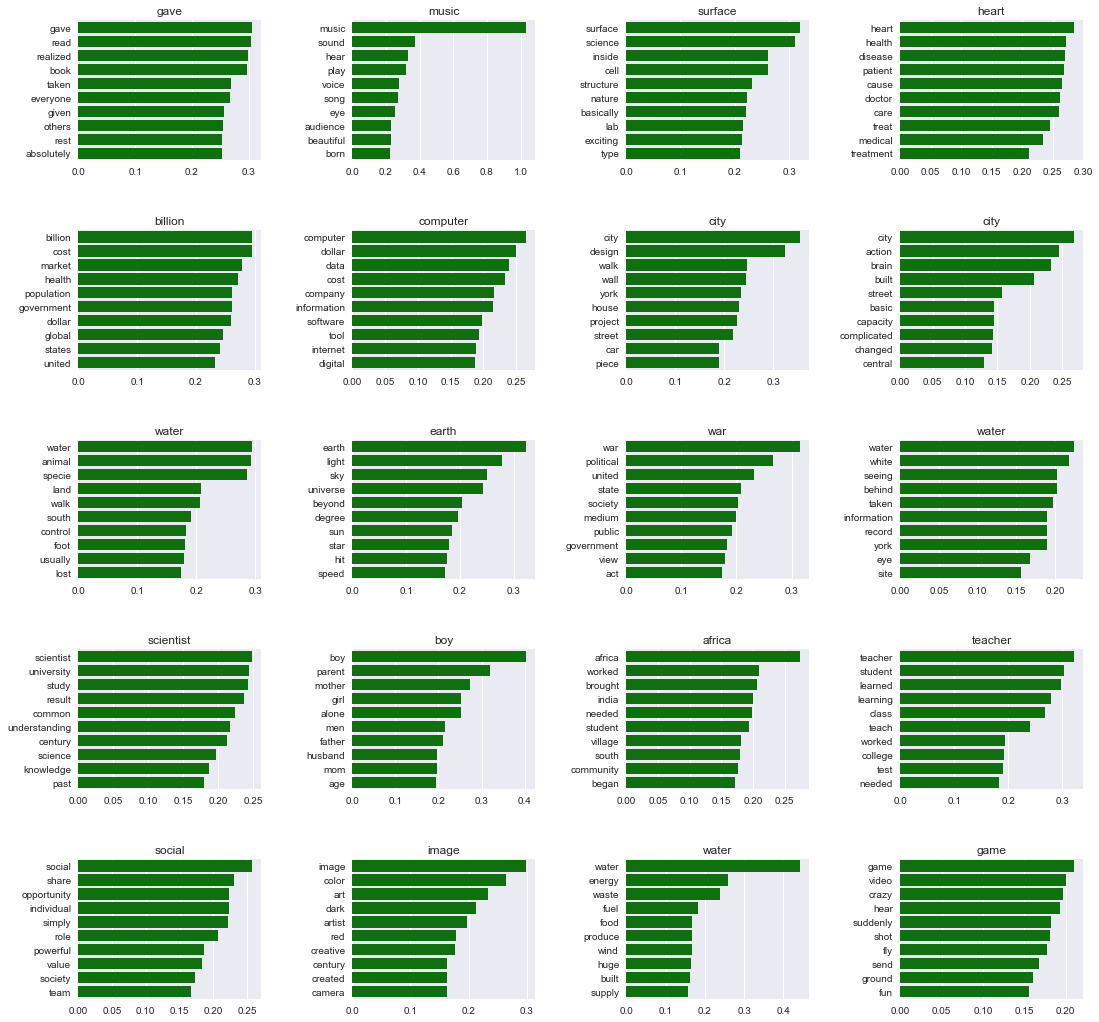

In [657]:
# just another method
# create 2 dictionaries: words and respective weights
top_n_words = 10
t_words, word_strengths = {}, {}
for t_id, t in enumerate(nmf_kl.components_):
    t_words[t_id] = [tfidf_vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
    
fig, ax = plt.subplots(figsize=(18,18), ncols=4, nrows=5)
plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.5
)
c=0
for row in range(0,5):
    for col in range(0,4):
        sns.barplot(x=word_strengths[c], y=t_words[c], color="green", ax=ax[row][col]).set_title(t_words[c][0])
        c+=1
plt.show()

#word_strengths
#t_words

In [660]:
pyLDAvis.sklearn.prepare(nmf_kl,tfidf,tfidf_vectorizer)

/Users/cristina/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/cristina/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/cristina/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/cristina/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:208: RuntimeWarning: invalid value encountered in multiply
  relevance = lambda_ * log_ttd + (1 - lambda_) * log_lift
/Users/cristina/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:208: RuntimeWarning: invalid value encountered in multiply
  relevance = lambda_ * log_ttd + (1 - lambda_) * log_lift


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      10.518886        1       1 -0.045547 -0.036592
2       6.156785        1       2  0.062435 -0.177623
5       6.102913        1       3  0.165422 -0.014810
4       5.584333        1       4  0.199203  0.216612
3       5.552869        1       5 -0.022235  0.055703
10      5.292501        1       6  0.101605  0.011550
6       5.205213        1       7 -0.206362 -0.016264
1       5.161268        1       8 -0.239672 -0.189509
16      5.031134        1       9  0.190005  0.018723
12      4.920013        1      10  0.189325 -0.109215
13      4.382924        1      11 -0.200821  0.133952
9       4.256225        1      12 -0.009061 -0.009610
11      4.190962        1      13 -0.077979  0.012816
17      4.139304        1      14  0.030690 -0.249847
15      4.107391        1      15 -0.018027  0.062531
14      4.057761        1      16 -0.112286  0.138134
7       4.055981        1      17  0.158813 -0.047657
8       3.896403        1      18 -0.107765  0.108344
19      3.835392        1      19 -0.186343  0.010906
18      3.551741        1      20  0.128601  0.081855, topic_info=     Category       Freq            Term      Total  loglift  logprob
term                                                                 
1536  Default  46.000000           music  46.000000  30.0000  30.0000
2544  Default  48.000000           water  48.000000  29.0000  29.0000
255   Default  25.000000             boy  25.000000  28.0000  28.0000
1118  Default  32.000000            hear  32.000000  27.0000  27.0000
380   Default  43.000000            city  43.000000  26.0000  26.0000
2182  Default  30.000000           sound  30.000000  25.0000  25.0000
1049  Default  28.000000            girl  28.000000  24.0000  24.0000
1669  Default  28.000000          parent  28.000000  23.0000  23.0000
2592  Default  35.000000          worked  35.000000  22.0000  22.0000
2261  Default  33.000000         student  33.000000  21.0000  21.0000
2337  Default  23.000000         teacher  23.000000  20.0000  20.0000
775   Default  25.000000          energy  25.000000  19.0000  19.0000
223   Default  32.000000         billion  32.000000  18.0000  18.0000
614   Default  29.000000          design  29.000000  17.0000  17.0000
284   Default  37.000000           built  37.000000  16.0000  16.0000
1183  Default  31.000000           image  31.000000  15.0000  15.0000
1115  Default  26.000000          health  26.000000  14.0000  14.0000
718   Default  28.000000           earth  28.000000  13.0000  13.0000
514   Default  24.000000            cost  24.000000  12.0000  12.0000
198   Default  30.000000       beautiful  30.000000  11.0000  11.0000
2508  Default  40.000000           video  40.000000  10.0000  10.0000
1163  Default  25.000000           house  25.000000   9.0000   9.0000
1519  Default  29.000000          mother  29.000000   8.0000   8.0000
2190  Default  22.000000          specie  22.000000   7.0000   7.0000
2610  Default  30.000000            york  30.000000   6.0000   6.0000
1742  Default  43.000000            play  43.000000   5.0000   5.0000
2042  Default  24.000000       scientist  24.000000   4.0000   4.0000
2479  Default  29.000000      university  29.000000   3.0000   3.0000
2040  Default  28.000000         science  28.000000   2.0000   2.0000
2476  Default  29.000000          united  29.000000   1.0000   1.0000
2267   Topic1   2.888038          stupid   2.888038   2.2520  -6.7961
11     Topic1   2.174098        absolute   2.615325   2.0672  -7.0800
2080   Topic1   3.147408       seriously   4.004777   2.0111  -6.7101
12     Topic1   6.907774      absolutely   8.902656   1.9983  -5.9240
1796   Topic1   1.963355    presentation   2.861594   1.8753  -7.1820
1576   Topic1   6.017745          nobody   9.117018   1.8366  -6.0619
1502   Topic1   3.196271         mistake   4.890811   1.8266  -6.6947
1562   Topic1   2.786482        negativ

# Plot model 2: main NMF - 
this is the model I've decided to move on for recommender and time series


In [286]:
t_words[1][0]

'music'

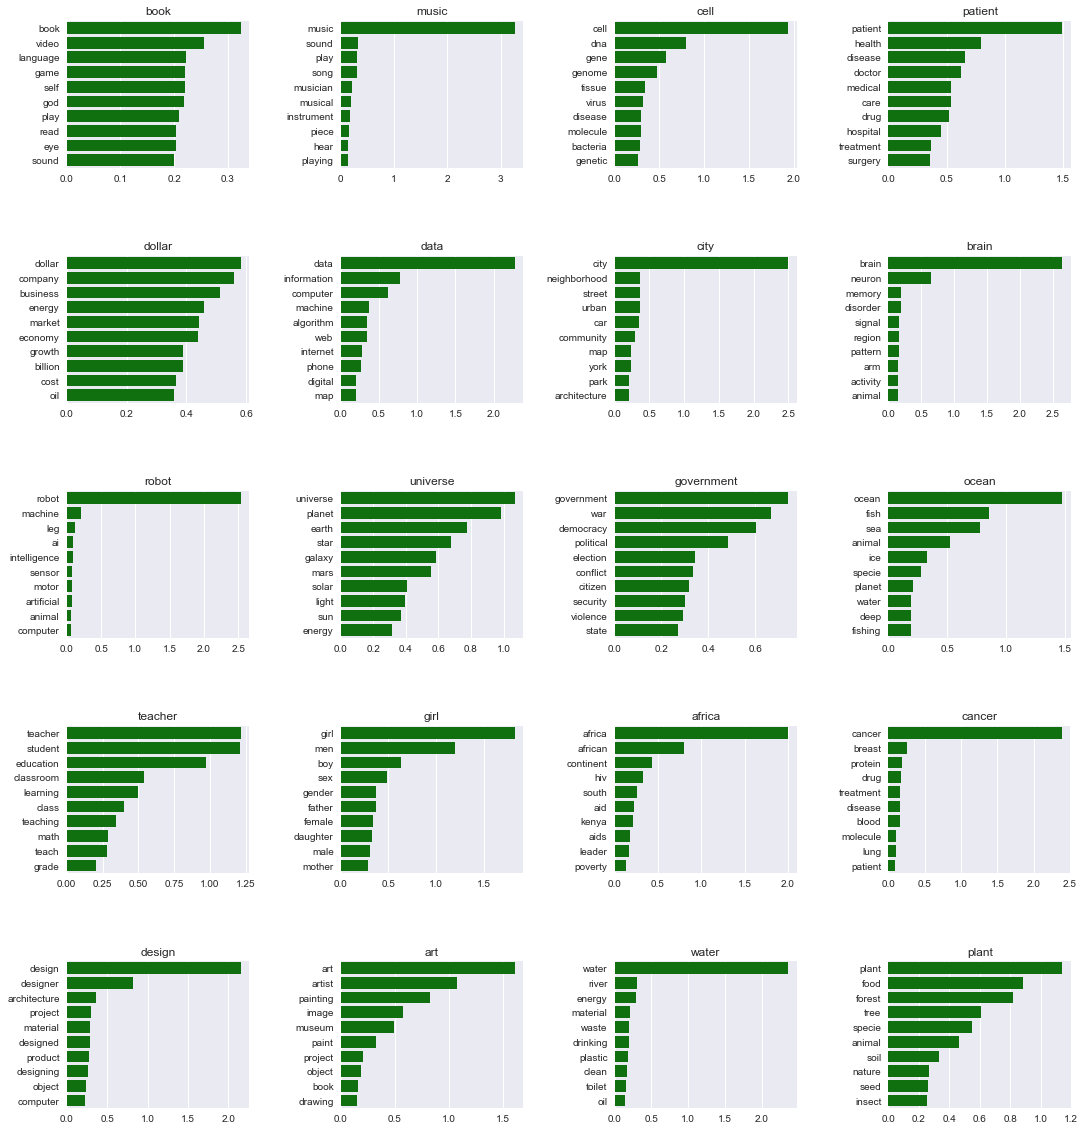

In [661]:
top_n_words = 10
t_words, word_strengths = {}, {}
for t_id, t in enumerate(nmf.components_):
    t_words[t_id] = [tfidf_vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
t_words
fig, ax = plt.subplots(figsize=(18,20), ncols=4, nrows=5)
plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.6
)
c=0
for row in range(0,5):
    for col in range(0,4):
        sns.barplot(x=word_strengths[c], y=t_words[c], color="green", ax=ax[row][col],).set_title(t_words[c][0])  #(f"topic {c+1}")
        c+=1
        
plt.show()

In [663]:
pyLDAvis.sklearn.prepare(nmf,tfidf,tfidf_vectorizer)

/Users/cristina/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/cristina/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/cristina/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/Users/cristina/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:208: RuntimeWarning: invalid value encountered in multiply
  relevance = lambda_ * log_ttd + (1 - lambda_) * log_lift
/Users/cristina/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:208: RuntimeWarning: invalid value encountered in multiply
  relevance = lambda_ * log_ttd + (1 - lambda_) * log_lift


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      33.651744        1       1  0.058428  0.086775
4       8.812923        1       2  0.020320  0.174778
10      7.475063        1       3  0.182505  0.188901
3       4.082936        1       4  0.143423 -0.204859
9       4.077503        1       5 -0.227568  0.031085
5       4.011934        1       6  0.046919 -0.037884
13      3.835852        1       7  0.226995  0.092122
19      3.474676        1       8 -0.232799  0.017254
6       3.307935        1       9 -0.041818  0.166063
7       3.158695        1      10 -0.017167 -0.204290
16      3.057744        1      11 -0.056474  0.003973
2       3.044671        1      12 -0.097990 -0.261392
11      2.946340        1      13 -0.279116  0.089314
12      2.905872        1      14  0.178987  0.044238
17      2.762869        1      15  0.052315  0.033716
1       2.538595        1      16  0.087934 -0.008576
18      2.515084        1      17 -0.270930  0.083197
14      1.895800        1      18  0.139691  0.126995
15      1.244115        1      19  0.062211 -0.334544
8       1.199648        1      20  0.024134 -0.086868, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
1536  Default  261.000000           music  261.000000  30.0000  30.0000
2005  Default  143.000000           robot  143.000000  29.0000  29.0000
256   Default  179.000000           brain  179.000000  28.0000  28.0000
303   Default  131.000000          cancer  131.000000  27.0000  27.0000
2544  Default  163.000000           water  163.000000  26.0000  26.0000
380   Default  166.000000            city  166.000000  25.0000  25.0000
614   Default  150.000000          design  150.000000  24.0000  24.0000
566   Default  161.000000            data  161.000000  23.0000  23.0000
56    Default  122.000000          africa  122.000000  22.0000  22.0000
1049  Default  136.000000            girl  136.000000  21.0000  21.0000
139   Default  120.000000             art  120.000000  20.0000  20.0000
331   Default  108.000000            cell  108.000000  19.0000  19.0000
1475  Default  101.000000             men  101.000000  18.0000  18.0000
2337  Default   81.000000         teacher   81.000000  17.0000  17.0000
2261  Default   88.000000         student   88.000000  16.0000  16.0000
142   Default   78.000000          artist   78.000000  15.0000  15.0000
1688  Default   90.000000         patient   90.000000  14.0000  14.0000
1605  Default   70.000000           ocean   70.000000  13.0000  13.0000
732   Default   80.000000       education   80.000000  12.0000  12.0000
1663  Default   58.000000        painting   58.000000  11.0000  11.0000
57    Default   51.000000         african   51.000000  10.0000  10.0000
616   Default   56.000000        designer   56.000000   9.0000   9.0000
1738  Default   62.000000           plant   62.000000   8.0000   8.0000
1224  Default   77.000000     information   77.000000   7.0000   7.0000
1183  Default   73.000000           image   73.000000   6.0000   6.0000
2478  Default   56.000000        universe   56.000000   5.0000   5.0000
1736  Default   74.000000          planet   74.000000   4.0000   4.0000
971   Default   61.000000            food   61.000000   3.0000   3.0000
452   Default   90.000000        computer   90.000000   2.0000   2.0000
255   Default   55.000000             boy   55.000000   1.0000   1.0000
245    Topic1    2.345981          boring    2.345981   1.0891  -8.1668
1844   Topic1    1.011329      proportion    1.011329   1.0891  -9.0083
317    Topic1    1.992741       carefully    1.992741   1.0891  -8.3300
1903   Topic1    2.091681        reaching    2.091681   1.0891  -8.2816
2550   Topic1    4.301830         wearing    4.301830   1.0891  -7.5605
656    Topic1    1.472062     disappeared    1.472062   1.0891  -8.6329
1791   Topic1    1.377901        

### Plot LDA

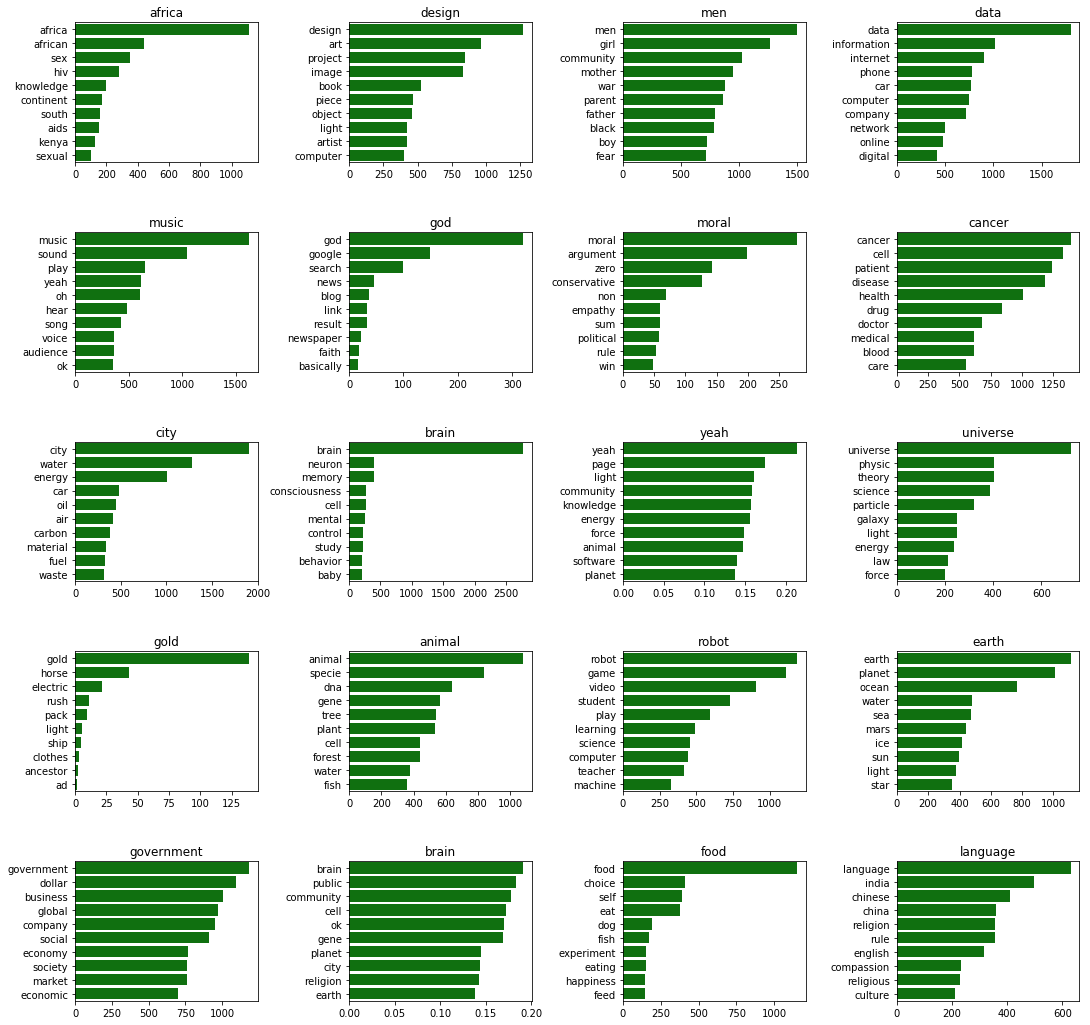

In [291]:
top_n_words = 10
t_words, word_strengths = {}, {}
for t_id, t in enumerate(lda.components_):
    t_words[t_id] = [tf_vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
t_words
fig, ax = plt.subplots(figsize=(18,18), ncols=4, nrows=5)
plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.5
)
c=0
for row in range(0,5):
    for col in range(0,4):
        sns.barplot(x=word_strengths[c], y=t_words[c], color="green", ax=ax[row][col]).set_title(t_words[c][0])
        c+=1
plt.show()

In [215]:
pyLDAvis.sklearn.prepare(lda,tf,tf_vectorizer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      20.735462        1       1 -0.035586  0.003605
16     14.351801        1       2 -0.063570 -0.087523
3       7.810187        1       3  0.019537  0.002045
1       7.297331        1       4  0.077679  0.039071
13      6.508893        1       5  0.095632 -0.020056
4       6.505549        1       6  0.050819  0.094346
8       6.314765        1       7  0.070883 -0.074022
14      6.261114        1       8  0.071199  0.066081
7       5.773720        1       9  0.045105 -0.090979
15      4.484240        1      10  0.133183 -0.028289
18      3.891859        1      11  0.024449  0.010799
9       3.871667        1      12  0.064352  0.028614
11      2.583989        1      13  0.120034  0.076756
19      1.541132        1      14 -0.216629  0.033891
0       1.064816        1      15 -0.134845 -0.291963
6       0.628304        1      16 -0.217976  0.161843
5       0.286077        1      17 -0.129368  0.084826
12      0.062667        1      18  0.007626 -0.008700
17      0.013213        1      19  0.006081 -0.000210
10      0.013213        1      20  0.011395 -0.000135, topic_info=     Category         Freq       Term        Total  loglift  logprob
term                                                                
292   Default  3373.000000      brain  3373.000000  30.0000  30.0000
110   Default  1466.000000     africa  1466.000000  29.0000  29.0000
1079  Default  1170.000000        god  1170.000000  28.0000  28.0000
416   Default  3043.000000       city  3043.000000  27.0000  27.0000
1552  Default  2071.000000      music  2071.000000  26.0000  26.0000
1353  Default  1402.000000   language  1402.000000  25.0000  25.0000
995   Default  1791.000000       food  1791.000000  24.0000  24.0000
1397  Default  2050.000000      light  2050.000000  23.0000  23.0000
339   Default  1451.000000     cancer  1451.000000  22.0000  22.0000
367   Default  2327.000000       cell  2327.000000  21.0000  21.0000
2532  Default  2696.000000      water  2696.000000  20.0000  20.0000
749   Default  1861.000000      earth  1861.000000  19.0000  19.0000
1584  Default  1066.000000       news  1066.000000  18.0000  18.0000
600   Default  2778.000000       data  2778.000000  17.0000  17.0000
1742  Default  1793.000000     planet  1793.000000  16.0000  16.0000
1046  Default  1451.000000       game  1451.000000  15.0000  15.0000
1696  Default  1356.000000    patient  1356.000000  14.0000  14.0000
1083  Default   623.000000     google   623.000000  13.0000  13.0000
2468  Default  1104.000000   universe  1104.000000  12.0000  12.0000
1233  Default   903.000000      india   903.000000  11.0000  11.0000
2009  Default  1237.000000      robot  1237.000000  10.0000  10.0000
1136  Default  1673.000000     health  1673.000000   9.0000   9.0000
695   Default  1423.000000    disease  1423.000000   8.0000   8.0000
804   Default  1767.000000     energy  1767.000000   7.0000   7.0000
2021  Default  1020.000000       rule  1020.000000   6.0000   6.0000
1763  Default  1037.000000  political  1037.000000   5.0000   5.0000
401   Default   879.000000      china   879.000000   4.0000   4.0000
1988  Default  1113.000000     result  1113.000000   3.0000   3.0000
2523  Default  1426.000000        war  1426.000000   2.0000   2.0000
646   Default  1928.000000     design  1928.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
2162  Topic20     0.094906   software   480.276454   0.4025  -7.1649
976   Topic20     0.054254       flew   133.140442   1.1262  -7.7241
1340  Topic20     0.106952  knowledge   875.972969  -0.0790  -7.0454
10    Topic20     0.078421         18   386.602572   0.4287  -7.3557
2513  Topic20     0.071483       vote   301.761860   0.5838  -7.4483
2195  Topic20     0.088072      speed   579.714273   0.1396  -7.2396
998   Topic20     0.100821      force   915.780251  -0.1825  -7.1044
1126  Top

In [216]:
#from MulticoreTSNE import MulticoreTSNE as TSNE
#tsne_model = TSNE(n_components=2, perplexity=50, verbose=2).fit_transform(nmf)
# or 

#tsne = TSNE(n_components=2)
#X_tsne = tsne.fit_transform(nmf[::40])

# plot with tsne!
#doc_max_top = np.argmax(nmf, axis=1 ) # nmf_fit?
#doc_max_top.shape
#plt.figure(figsize=(12,12))
#plt.scatter(X_tsne[:,0],X_tsne[:,1], c=doc_max_top[::40], alpha=1,s=2)
#plt.title("multicore-tsne + nmf + subject with max topic labels");
#plt.legend(np.arange(1,10));
#plt.savefig("tsne w euc.pdf")

###  Create document-topic and topic-word matrices for NMF model

In [133]:
nmf_topics_df = pd.DataFrame(nmf_topics)
nmf_words_df = pd.DataFrame(nmf.components_)
print(nmf_topics_df.shape, nmf_words_df.shape)

(2467, 20) (20, 2605)


- label the dfs
- pickle
- integrate with other data

### Dig into my topics and understand how they are distributed overall

In [582]:
w = 'catch all, music, cell biology, ocean and environment, health and medical, business and economy, city and urban, brain, robotics and ai, cosmology and astronomy, government and politics, data, education, women, africa, cancer, design, art, water, plants and nature'
topics = w.split(', ')


In [587]:
topic_list = [(i,t) for i, t in enumerate(topics)]
topic_list
#topics


[(0, 'catch all'),
 (1, 'music'),
 (2, 'cell biology'),
 (3, 'ocean and environment'),
 (4, 'health and medical'),
 (5, 'business and economy'),
 (6, 'city and urban'),
 (7, 'brain'),
 (8, 'robotics and ai'),
 (9, 'cosmology and astronomy'),
 (10, 'government and politics'),
 (11, 'data'),
 (12, 'education'),
 (13, 'women'),
 (14, 'africa'),
 (15, 'cancer'),
 (16, 'design'),
 (17, 'art'),
 (18, 'water'),
 (19, 'plants and nature')]

In [606]:
for i, el in enumerate(topics):
    print(el,'-', topics_log[i+2])

catch all - ['Topic #0: book video game language god self play oh yeah read']
music - ['Topic #1: music sound play song musician musical instrument piece hear playing']
cell biology - ['Topic #2: cell dna gene genome tissue virus disease molecule bacteria genetic']
ocean and environment - ['Topic #3: ocean fish sea animal ice specie planet water deep fishing']
health and medical - ['Topic #4: patient health disease doctor medical care drug hospital treatment surgery']
business and economy - ['Topic #5: dollar company business energy market economy billion growth cost oil']
city and urban - ['Topic #6: city neighborhood street urban car community york map park architecture']
brain - ['Topic #7: brain neuron memory disorder signal region pattern arm activity animal']
robotics and ai - ['Topic #8: robot machine leg ai intelligence sensor motor artificial animal computer']
cosmology and astronomy - ['Topic #9: universe planet earth star galaxy mars solar light sun energy']
government and p

In [594]:
t_words

{0: ['africa',
  'african',
  'sex',
  'hiv',
  'knowledge',
  'continent',
  'south',
  'aids',
  'kenya',
  'sexual'],
 1: ['design',
  'art',
  'project',
  'image',
  'book',
  'piece',
  'object',
  'light',
  'artist',
  'computer'],
 2: ['men',
  'girl',
  'community',
  'mother',
  'war',
  'parent',
  'father',
  'black',
  'boy',
  'fear'],
 3: ['data',
  'information',
  'internet',
  'phone',
  'car',
  'computer',
  'company',
  'network',
  'online',
  'digital'],
 4: ['music',
  'sound',
  'play',
  'yeah',
  'oh',
  'hear',
  'song',
  'voice',
  'audience',
  'ok'],
 5: ['god',
  'google',
  'search',
  'news',
  'blog',
  'link',
  'result',
  'newspaper',
  'faith',
  'basically'],
 6: ['moral',
  'argument',
  'zero',
  'conservative',
  'non',
  'empathy',
  'sum',
  'political',
  'rule',
  'win'],
 7: ['cancer',
  'cell',
  'patient',
  'disease',
  'health',
  'drug',
  'doctor',
  'medical',
  'blood',
  'care'],
 8: ['city',
  'water',
  'energy',
  'car',
  '

#### what are the most prevalent combinations of top 2 topics:
What's noted immediately is that topic 0 that is my noise/catchall topic

In [253]:
from copy import deepcopy
top2 = []
cp = deepcopy(nmf_topics)
for a in cp:
    a = list(a)
    b = sorted(a, reverse=True)
    t1 = a.index(b[0])
    if b[0]==b[1]:
        a.remove(b[0])
        t2 = a.index(b[1])+1
    else:
        t2 = a.index(b[1])
    if t1<t2:
        top2.append((t1,t2))
    else:
        top2.append((t2,t1))

In [571]:
pd.Series(top2).value_counts()

(0, 10)     222
(0, 5)      187
(0, 1)      151
(0, 13)     138
(0, 11)     123
(0, 12)     117
(0, 9)      110
(0, 4)      102
(0, 7)      101
(0, 17)      92
(0, 16)      83
(0, 19)      78
(5, 10)      66
(0, 6)       57
(0, 3)       57
(0, 18)      52
(0, 2)       46
(0, 8)       35
(5, 6)       28
(0, 14)      27
(5, 14)      23
(2, 4)       22
(4, 15)      22
(5, 19)      20
(0, 15)      20
(5, 11)      17
(3, 18)      16
(3, 9)       15
(3, 5)       15
(5, 18)      15
(5, 9)       14
(2, 15)      14
(2, 7)       14
(2, 19)      13
(18, 19)     13
(4, 14)      12
(10, 11)     12
(6, 16)      12
(6, 10)      12
(3, 19)      12
(10, 13)     11
(4, 11)      10
(2, 9)       10
(4, 10)       8
(4, 5)        8
(5, 12)       7
(5, 16)       7
(9, 18)       7
(4, 7)        7
(6, 19)       6
(10, 17)      6
(2, 5)        6
(4, 16)       6
(9, 11)       5
(6, 18)       5
(2, 18)       5
(12, 13)      5
(6, 11)       4
(6, 17)       4
(5, 15)       3
(7, 11)       3
(11, 14)      3
(11, 19)

In [579]:
pd.Series(top2)[pd.Series(top2) == (8, 11)].value_counts()

(8, 11)    3
dtype: int64

In [ ]:
PLOT!!!!

### topic distribution
note that topic0, which is my catchall is most prevalent.
Let's shuffle that a little: if my talk corresponds to topic0 then I'll check my next best match - and select that based on a threshhold

In [265]:
from copy import deepcopy
#top2 = []
top = []
cp = deepcopy(nmf_topics)
for a in cp:
    a = list(a) #set to a list so that I can sort in my next lihe
    b = sorted(a, reverse=True)
    t1 = a.index(b[0])
    if b[0]==b[1]:
        a.remove(b[0])
        t2 = a.index(b[1])+1
    else:
        t2 = a.index(b[1])
    top.append(t1)    


In [429]:
pd.Series(top).value_counts()

0     905
5     206
10    178
4      99
9      96
2      91
19     86
1      85
6      79
7      78
3      73
11     71
13     70
16     65
12     59
17     58
18     54
14     41
15     37
8      36
dtype: int64

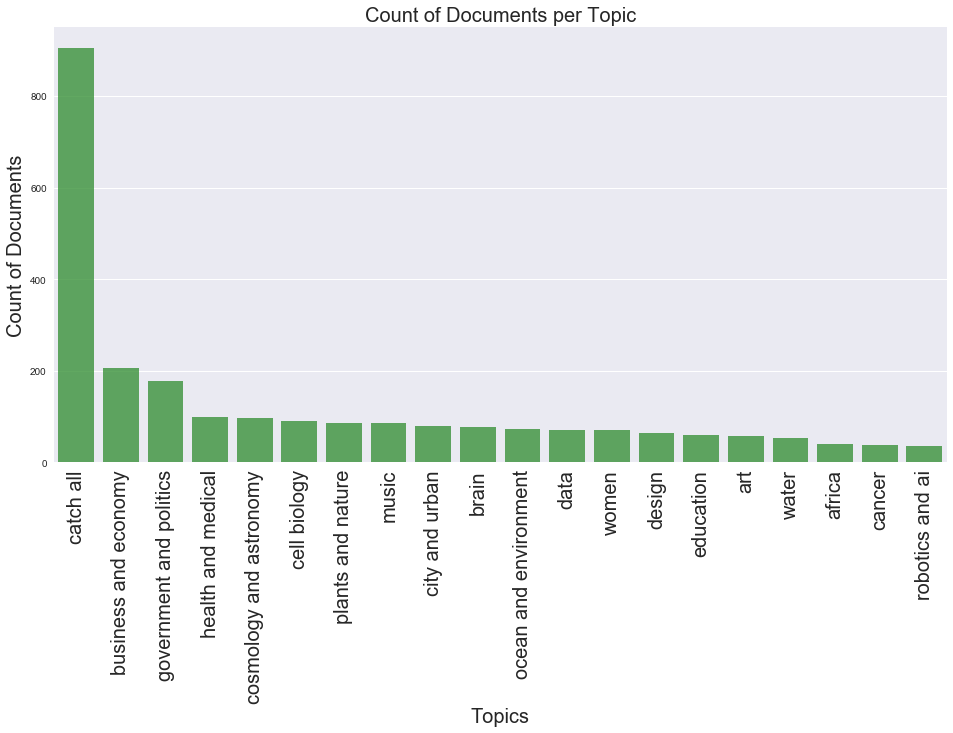

In [664]:
plt.figure(figsize=(16,8))
x = [topics[i] for i in pd.Series(top).value_counts().index] # instead of printing topic#, fetch topic-label from topics list by index 
y = pd.Series(top).value_counts() # value counts
sns.barplot(x, y, alpha=0.8, color=color[2])
plt.xlabel('Topics', fontsize=20)
plt.ylabel('Count of Documents', fontsize=20)
plt.xticks(fontsize = 20)
plt.xticks(rotation='vertical')
plt.title("Count of Documents per Topic", fontsize=20)
plt.show()

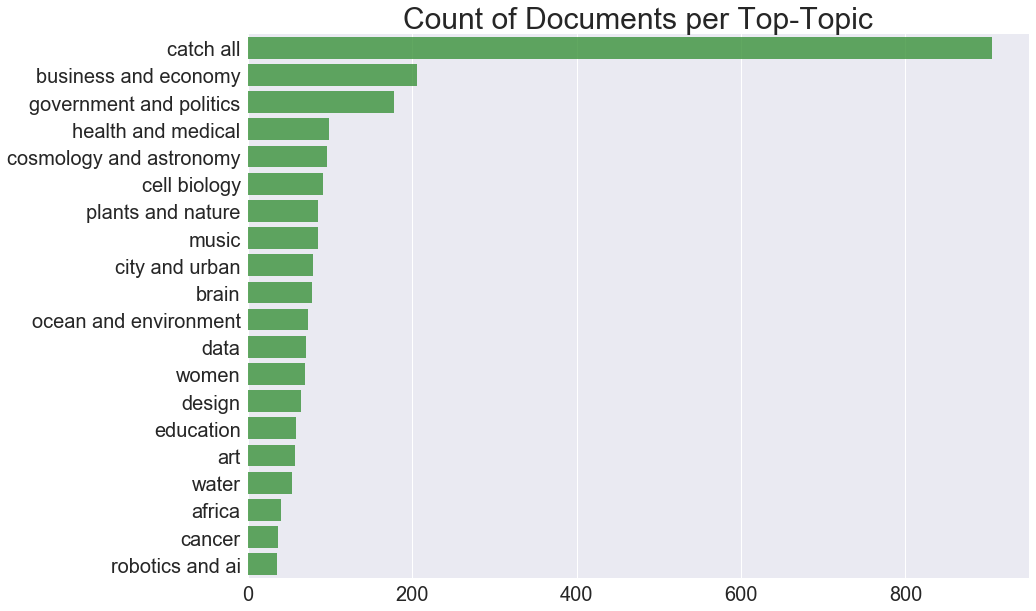

In [672]:
plt.figure(figsize=(14,10))
y = [topics[i] for i in pd.Series(top).value_counts().index] # instead of printing topic#, fetch topic-label from topics list by index 
x = pd.Series(top).value_counts() # value counts
sns.barplot(x, y, alpha=0.8, color=color[2])
#plt.xlabel('Topics', fontsize=20)
#plt.ylabel('Count of Documents', fontsize=20)
plt.yticks(fontsize = 20)
plt.xticks(fontsize = 20)
#plt.xticks(rotation='vertical')
plt.title("Count of Documents per Top-Topic", fontsize=30)
plt.show()

### topic distribution - penalizing the topic 0


In [267]:
from copy import deepcopy

#top2 = []
top_0 = []
#cp = deepcopy(nmf_topics)
for a in cp:
    a = list(a)
    b = sorted(a, reverse=True)
    t1 = a.index(b[0])
    if b[0]==b[1]:
        a.remove(b[0])
        t2 = a.index(b[1])+1
    else:
        t2 = a.index(b[1])
    #if t1<t2:
     #   top2.append((t1,t2))
    #else:
    #top2.append((t2,t1))
    if t1==0 and b[1]>0.3*b[0]:
        top_0.append(t2)
    else:
        top_0.append(t1)

In [431]:
pd.Series(top_0).value_counts()

5     284
10    266
0     236
4     138
13    130
11    129
9     128
1     123
19    119
7     113
12    108
16    103
2     102
6      98
3      93
17     92
18     73
14     49
8      44
15     39
dtype: int64

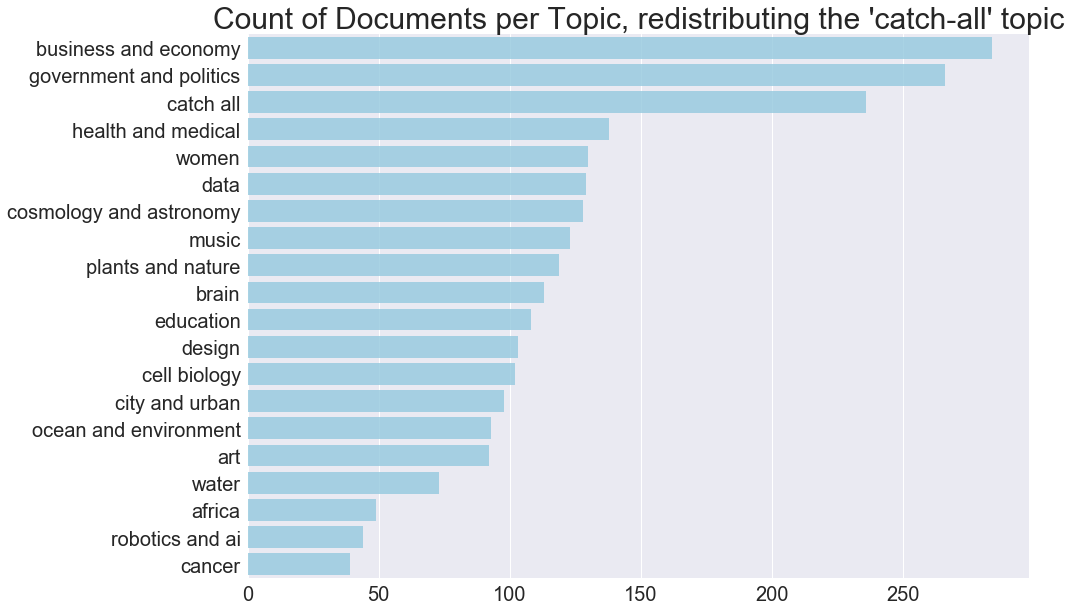

In [675]:
plt.figure(figsize=(14,10))
sns.set()
y = [topics[i] for i in pd.Series(top_0).value_counts().index] # instead of printing topic#, fetch topic-label from topics list by index 
x = pd.Series(top_0).value_counts() # value counts
sns.barplot(x, y, alpha=0.8, color='skyblue')
#plt.xlabel('Topics', fontsize=20)
#plt.ylabel('Count of Documents', fontsize=20)
plt.xticks( fontsize = 20) #, rotation='vertical',)
plt.yticks( fontsize = 20)
plt.title("Count of Documents per Topic, redistributing the 'catch-all' topic", fontsize=30)
plt.show()

#topics # list of lables for topics

In [275]:
##### Pickle my lists of TOP topics and TOP2 topics
with open('pickle/top2.pkl', 'wb') as picklefile:
    pickle.dump(top2, picklefile)
with open('pickle/top.pkl', 'wb') as picklefile:
    pickle.dump(top, picklefile)
with open('pickle/top_0.pkl', 'wb') as picklefile:
    pickle.dump(top_0, picklefile) 
    
# write a for loop for the above files    

In [198]:
# pickle the document/topic df
with open('nmf_topics_df.pkl', 'wb') as picklefile:
    pickle.dump(nmf_topics_df, picklefile)

In [308]:
# unpickle
#with open("nmf_topics_df.pkl", 'rb') as picklefile: 
    #new_test = pickle.load(picklefile)

## Integrate topics into main df
top, top_0, top2

In [319]:
df['top_topic'] = pd.Series(top).values
df['top_topic_less0'] = pd.Series(top_0).values
df['top2_topics'] = pd.Series(top2).values

In [512]:
df.sample(2)

transcript  \
410  I started with paragliding. Paragliding is tak...   
367  You know, I am so bad at tech that my daughter...   

                                                   url  comments  \
410  https://www.ted.com/talks/ueli_gegenschatz_ext...       117   
367  https://www.ted.com/talks/sherwin_nuland_on_ho...        35   

                                           description  duration    event  \
410  Wingsuit jumping is the leading edge of extrem...       733  TED2009   
367  Sherwin Nuland, a surgeon and a writer, medita...       756  TED2003   

      film_date  languages      main_speaker  \
410  1233878400         25  Ueli Gegenschatz   
367  1044144000         23    Sherwin Nuland   

                                                  name  num_speaker  \
410          Ueli Gegenschatz: Extreme wingsuit flying            1   
367  Sherwin Nuland: The extraordinary power of ord...            1   

     published_date                                            ratings  \
410      1238547600  [{'id': 3, 'name': 'Courageous', 'count': 354}...   
367      1232672400  [{'id': 25, 'name': 'OK', 'count': 60}, {'id':...   

                                         related_talks speaker_occupation  \
410  [{'id': 89, 'hero': 'https://pe.tedcdn.com/ima...          Aerialist   
367  [{'id': 189, 'hero': 'https://pe.tedcdn.com/im...             Doctor   

                                                  tags  \
410  ['adventure', 'design', 'entertainment', 'expl...   
367          ['philanthropy', 'philosophy', 'writing']   

                                          title    views  \
410                     Extreme wingsuit flying  1442990   
367  The extraordinary power of ordinary people   326663   

                                        transcript_lem  top_topic  \
410  I started with paragliding Paragliding is taki...          0   
367  You know I am so bad at tech that my daughter ...          0   

     top_topic_less0 top2_topics       date  year  
410                0      (0, 9) 2009-02-06  2009  
367                4      (0, 4) 2003-02-02  2003

In [953]:
## convert time to datetime and extract year
df['date'] = pd.to_datetime(df['published_date'],unit='s')

In [954]:
df['year'] = pd.DatetimeIndex(df['date']).year

In [955]:
#df = df.rename(columns={'date': 'film_date', 'year': 'film_year'} )
df.head()

transcript  \
0  Good morning. How are you?(Laughter)It's been ...   
1  Thank you so much, Chris. And it's truly a gre...   
2  (Music: "The Sound of Silence," Simon & Garfun...   
3  If you're here today — and I'm very happy that...   
4  About 10 years ago, I took on the task to teac...   

                                                 url  comments  \
0  https://www.ted.com/talks/ken_robinson_says_sc...      4553   
1  https://www.ted.com/talks/al_gore_on_averting_...       265   
2  https://www.ted.com/talks/david_pogue_says_sim...       124   
3  https://www.ted.com/talks/majora_carter_s_tale...       200   
4  https://www.ted.com/talks/hans_rosling_shows_t...       593   

                                         description  duration    event  \
0  Sir Ken Robinson makes an entertaining and pro...      1164  TED2006   
1  With the same humor and humanity he exuded in ...       977  TED2006   
2  New York Times columnist David Pogue takes aim...      1286  TED2006   
3  In an emotionally charged talk, MacArthur-winn...      1116  TED2006   
4  You've never seen data presented like this. Wi...      1190  TED2006   

    film_date  languages   main_speaker  \
0  1140825600         60   Ken Robinson   
1  1140825600         43        Al Gore   
2  1140739200         26    David Pogue   
3  1140912000         35  Majora Carter   
4  1140566400         48   Hans Rosling   

                                            name  num_speaker  published_date  \
0      Ken Robinson: Do schools kill creativity?            1      1151367060   
1           Al Gore: Averting the climate crisis            1      1151367060   
2                  David Pogue: Simplicity sells            1      1151367060   
3             Majora Carter: Greening the ghetto            1      1151367060   
4  Hans Rosling: The best stats you've ever seen            1      1151440680   

                                             ratings  \
0  [{'id': 7, 'name': 'Funny', 'count': 19645}, {...   
1  [{'id': 7, 'name': 'Funny', 'count': 544}, {'i...   
2  [{'id': 7, 'name': 'Funny', 'count': 964}, {'i...   
3  [{'id': 3, 'name': 'Courageous', 'count': 760}...   
4  [{'id': 9, 'name': 'Ingenious', 'count': 3202}...   

                                       related_talks  \
0  [{'id': 865, 'hero': 'https://pe.tedcdn.com/im...   
1  [{'id': 243, 'hero': 'https://pe.tedcdn.com/im...   
2  [{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...   
3  [{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...   
4  [{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...   

                     speaker_occupation  \
0                       Author/educator   
1                      Climate advocate   
2                  Technology columnist   
3    Activist for environmental justice   
4  Global health expert; data visionary   

                                                tags  \
0  ['children', 'creativity', 'culture', 'dance',...   
1  ['alternative energy', 'cars', 'climate change...   
2  ['computers', 'entertainment', 'interface desi...   
3  ['MacArthur grant', 'activism', 'business', 'c...   
4  ['Africa', 'Asia', 'Google', 'demo', 'economic...   

                             title     views  \
0      Do schools kill creativity?  47227110   
1      Averting the climate crisis   3200520   
2                 Simplicity sells   1636292   
3              Greening the ghetto   1697550   
4  The best stats you've ever seen  12005869   

                                      transcript_lem  top_topic  \
0  Good morning How are you Laughter It 's been g...         12   
1  Thank you so much Chris And it 's truly a grea...          5   
2  Music The Sound of Silence Simon Garfunkel Hel...          0   
3  If you 're here today — and I 'm very happy th...          6   
4  About 10 year ago I took on the task to teach ...         14   

   top_topic_less0 top2_topics  film_date  film_year                date  year  
0               12     (0, 12) 2006-02-25       2006 2006-06-27 00:1

### Plot topics over time

In [956]:
time_df = df[['title','top_topic','top_topic_less0','top2_topics', 'year']].copy(deep = True)

In [957]:
time_df.head()

title  top_topic  top_topic_less0 top2_topics  \
0      Do schools kill creativity?         12               12     (0, 12)   
1      Averting the climate crisis          5                5      (0, 5)   
2                 Simplicity sells          0               16     (0, 16)   
3              Greening the ghetto          6                6      (0, 6)   
4  The best stats you've ever seen         14               14    (11, 14)   

   year  
0  2006  
1  2006  
2  2006  
3  2006  
4  2006

In [958]:
topic_by_year = time_df.groupby(['year','top_topic_less0']).count()
topic_by_year = topic_by_year.reset_index()

In [961]:
topic_by_year =  topic_by_year.drop(['top_topic','top2_topics'], 1)

In [962]:
topic_by_year.columns = ['year','topic','counts']
topic_by_year.head()

year  topic  counts
0  2006      0       3
1  2006      1       4
2  2006      2       2
3  2006      3       1
4  2006      4       5

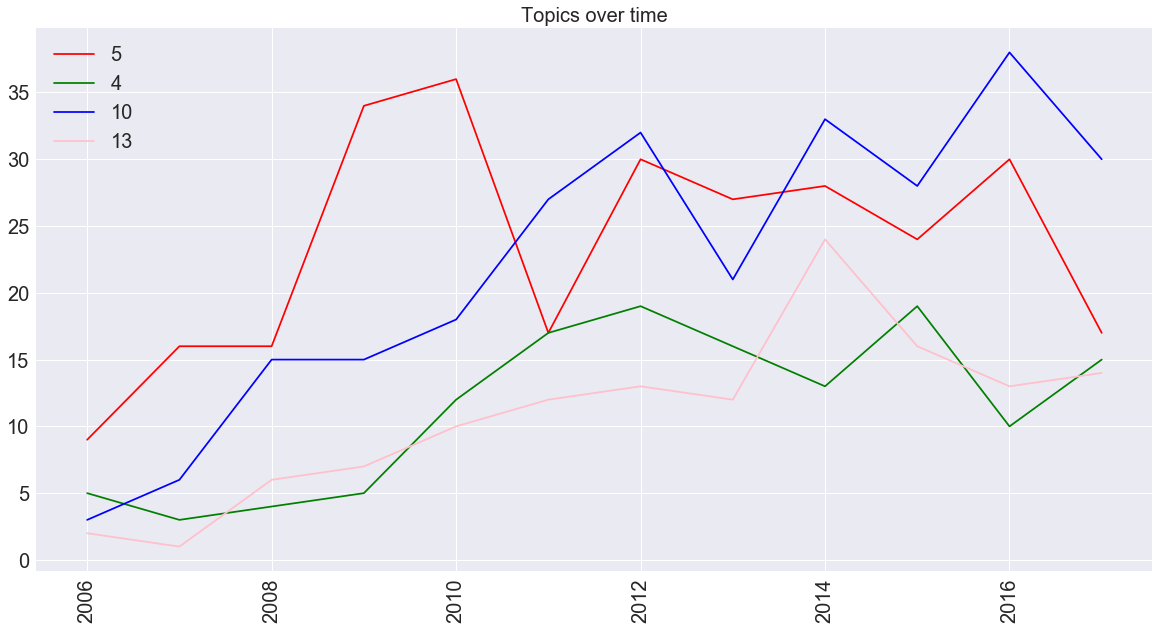

In [964]:
plt.figure(figsize=(20, 10))
x5 = topic_by_year.year[(topic_by_year['topic'] == 5) & (topic_by_year['year'] > 2005)]
y5 = topic_by_year['counts'][(topic_by_year['topic'] == 5) & (topic_by_year['year'] > 2005)]
x10 = topic_by_year.year[(topic_by_year['topic'] == 10) & (topic_by_year['year'] > 2005)]
y10 = topic_by_year['counts'][(topic_by_year['topic'] == 10) & (topic_by_year['year'] > 2005)]
x4 = topic_by_year.year[(topic_by_year['topic'] == 4) & (topic_by_year['year'] > 2005)]
y4 = topic_by_year['counts'][(topic_by_year['topic'] == 4) & (topic_by_year['year'] > 2005)]
x13 = topic_by_year.year[(topic_by_year['topic'] == 13) & (topic_by_year['year'] > 2005)]
y13 = topic_by_year['counts'][(topic_by_year['topic'] == 13) & (topic_by_year['year'] > 2005)]

plt.plot(x5, y5, c='red', label = '5')
plt.plot(x4, y4, c='green', label = '4')
plt.plot(x10, y10, c='blue', label = '10')
plt.plot(x13, y13, c='pink', label = '13')
plt.xticks(rotation='vertical', fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Topics over time', fontsize=20)
plt.legend([5, 4, 10, 13], fontsize = 20)



- to do:topics per year
check total 
divide by total count of topics to normalize


In [ ]:
# sanity check on document count

topic_by_year[topic_by_year.year > 2005]['counts'].sum()

note: there are some talks that have been filmed in the 80s or 90s and published in 2006

In [971]:
# create a df with years after 2005
tby06 = topic_by_year[topic_by_year.year > 2005].copy(deep = True)


In [972]:
# count of documents for all topics by year
t_all = pd.DataFrame(tby06.groupby('year')['counts'].sum()).reset_index()
t_all

year  counts
0   2006      50
1   2007     119
2   2008     185
3   2009     215
4   2010     233
5   2011     247
6   2012     279
7   2013     241
8   2014     240
9   2015     220
10  2016     243
11  2017     195

In [973]:
# function to create dfs of count of documents per specific topics by year
def topic_year_df(num):
    return pd.DataFrame(tby06[tby06.topic == num].groupby('year')['counts'].sum()).reset_index()
def name(num):
    return 't_'+str(num)

In [981]:
t_0 = topic_year_df(0)
t_1 = topic_year_df(1)
t_2 = topic_year_df(2)
t_3 = topic_year_df(3)
t_4 = topic_year_df(4)
t_5 = topic_year_df(5)
t_6 = topic_year_df(6)
t_7 = topic_year_df(7)
t_8 = topic_year_df(8)
t_9 = topic_year_df(9)
t_10 = topic_year_df(10)
t_11 = topic_year_df(11)
t_12 = topic_year_df(12)
t_13 = topic_year_df(13)
t_14 = topic_year_df(14)
t_15 = topic_year_df(15)
t_16 = topic_year_df(16)
t_17 = topic_year_df(17)
t_18 = topic_year_df(18)
t_19 = topic_year_df(19)

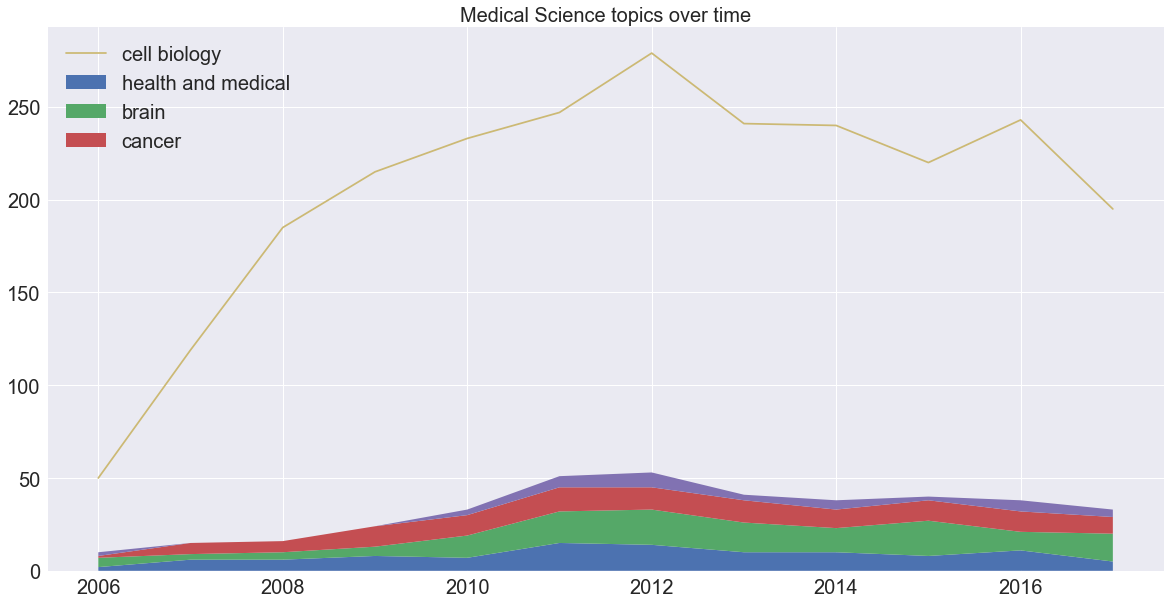

In [992]:
# 2, 4, 7, 15
x = t_all.year
#t_15 = t_15.append(h).sort_values('year').reset_index().drop('index', 1)
y=[ t_2.counts, t_4.counts,t_7.counts,  t_15.counts]
 
# Plot
plt.figure(figsize=(20, 10))
plt.stackplot(x,y)
plt.plot(t_all.year, t_all.counts)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Medical Science topics over time', fontsize=20)
plt.legend([topics[2], topics[4], topics[7], topics[15]], fontsize = 20, loc='upper left')
plt.show()


In [848]:
topic_list

[(0, 'catch all'),
 (1, 'music'),
 (2, 'cell biology'),
 (3, 'ocean and environment'),
 (4, 'health and medical'),
 (5, 'business and economy'),
 (6, 'city and urban'),
 (7, 'brain'),
 (8, 'robotics and ai'),
 (9, 'cosmology and astronomy'),
 (10, 'government and politics'),
 (11, 'data'),
 (12, 'education'),
 (13, 'women'),
 (14, 'africa'),
 (15, 'cancer'),
 (16, 'design'),
 (17, 'art'),
 (18, 'water'),
 (19, 'plants and nature')]

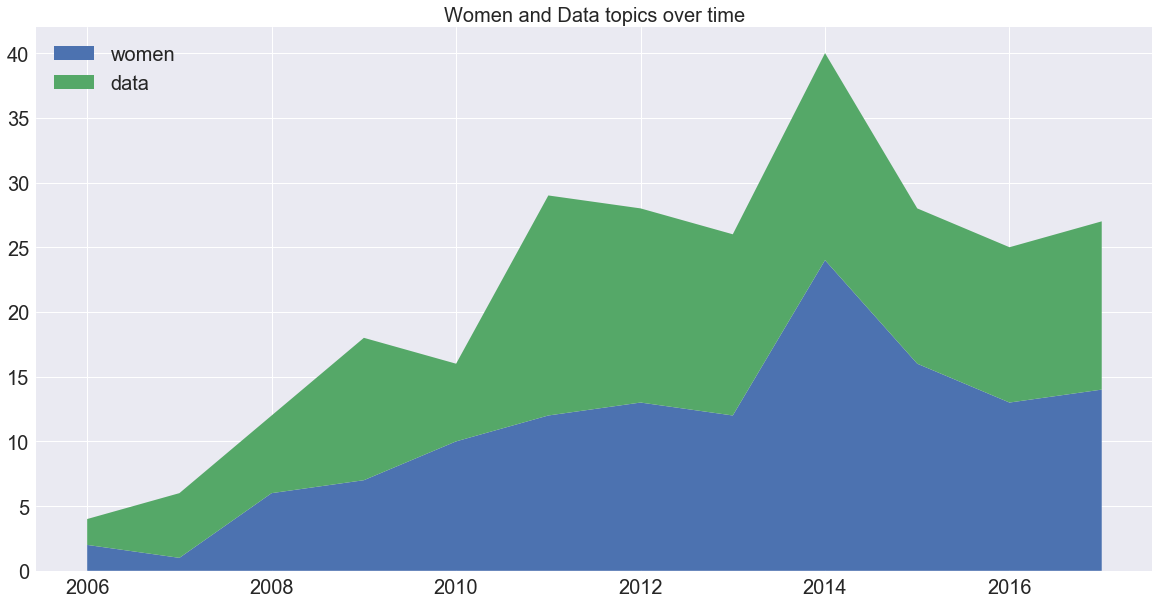

In [993]:
#13, 11 
x = t_all.year
#t_15 = t_15.append(h).sort_values('year').reset_index().drop('index', 1)
y=[  t_13.counts,t_11.counts]
 
# Plot
plt.figure(figsize=(20, 10))
plt.stackplot(x,y)
#plt.plot(t_all.year, t_all.counts)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Women and Data topics over time', fontsize=20)
plt.legend([topics[13], topics[11]], fontsize = 20, loc='upper left')
plt.show()


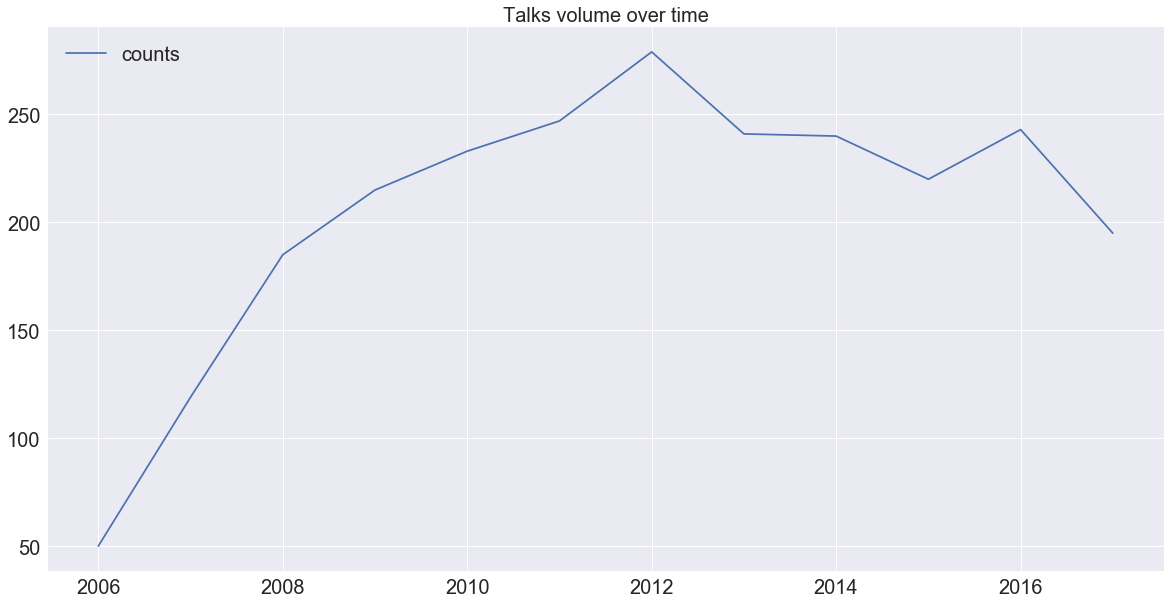

In [988]:
#13, 11 
#x = t_all.year
#t_15 = t_15.append(h).sort_values('year').reset_index().drop('index', 1)
#y=[  t_13.counts,t_11.counts]
 
# Plot
plt.figure(figsize=(20, 10))
#plt.plot(t_13.year, t_13.counts)
#plt.plot(t_11.year, t_11.counts)
plt.plot(t_all.year, t_all.counts)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Talks volume over time', fontsize=20)
plt.legend( fontsize = 20, loc='upper left')
plt.show()


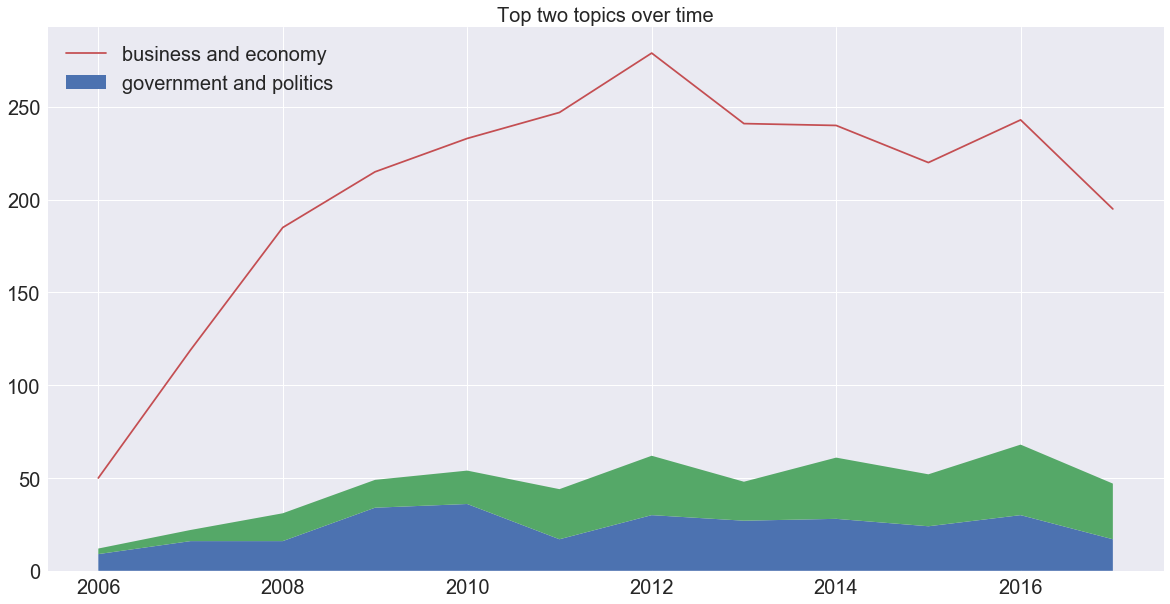

In [990]:
#13, 11 
x = t_all.year
#t_15 = t_15.append(h).sort_values('year').reset_index().drop('index', 1)
y=[   t_5.counts, t_10.counts]
 
# Plot
plt.figure(figsize=(20, 10))
plt.stackplot(x,y)
plt.plot(t_all.year, t_all.counts)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Top two topics over time', fontsize=20)
plt.legend([topics[5],topics[10]], fontsize = 20, loc='upper left')
plt.show()


### Recommender based on cosine similarity

In [158]:
from  sklearn.metrics.pairwise  import cosine_similarity

In [455]:
# 1) create similarity matrix
sim=cosine_similarity(nmf_topics_df)
sim.shape

(2467, 2467)

In [457]:
print(np.argsort(sim[1])[-5:])

[1091 1135 2455  290    1]


In [513]:
df.head(20)

transcript  \
0   Good morning. How are you?(Laughter)It's been ...   
1   Thank you so much, Chris. And it's truly a gre...   
2   (Music: "The Sound of Silence," Simon & Garfun...   
3   If you're here today — and I'm very happy that...   
4   About 10 years ago, I took on the task to teac...   
5   Thank you. I have to tell you I'm both challen...   
6   On September 10, the morning of my seventh bir...   
7   I'm going to present three projects in rapid f...   
8   It's wonderful to be back. I love this wonderf...   
9   I'm often asked, "What surprised you about the...   
10  I'm going to take you on a journey very quickl...   
11  I can't help but this wish: to think about whe...   
12  I'm the luckiest guy in the world. I got to se...   
13  I'm really excited to be here today. I'll show...   
14  I've been at MIT for 44 years. I went to TED I...   
15  (Music)(Music ends)(Applause)(Applause ends)Hi...   
16  (Music)(Music ends)(Applause)Thank you!(Applau...   
17  In terms of invention, I'd like to tell you th...   
18  My name is Lovegrove. I only know nine Lovegro...   
19  Charles Van Doren, who was later a senior edit...   

                                                  url  comments  \
0   https://www.ted.com/talks/ken_robinson_says_sc...      4553   
1   https://www.ted.com/talks/al_gore_on_averting_...       265   
2   https://www.ted.com/talks/david_pogue_says_sim...       124   
3   https://www.ted.com/talks/majora_carter_s_tale...       200   
4   https://www.ted.com/talks/hans_rosling_shows_t...       593   
5   https://www.ted.com/talks/tony_robbins_asks_wh...       672   
6   https://www.ted.com/talks/julia_sweeney_on_let...       919   
7   https://www.ted.com/talks/joshua_prince_ramus_...        46   
8   https://www.ted.com/talks/dan_dennett_s_respon...       852   
9   https://www.ted.com/talks/rick_warren_on_a_lif...       900   
10  https://www.ted.com/talks/cameron_sinclair_on_...        79   
11  https://www.ted.com/talks/jehane_noujaim_inspi...        55   
12  https://www.ted.com/talks/larry_brilliant_want...        71   
13  https://www.ted.com/talks/jeff_han_demos_his_b...       242   
14  https://www.ted.com/talks/nicholas_negroponte_...        99   
15  https://www.ted.com/talks/sirena_huang_dazzles...       325   
16  https://www.ted.com/talks/jennifer_lin_improvs...       305   
17  https://www.ted.com/talks/amy_smith_shares_sim...        88   
18  https://www.ted.com/talks/ross_lovegrove_share...       163   
19  https://www.ted.com/talks/jimmy_wales_on_the_b...        84   

                                          description  duration  \
0   Sir Ken Robinson makes an entertaining and pro...      1164   
1   With the same humor and humanity he exuded in ...       977   
2   New York Times columnist David Pogue takes aim...      1286   
3   In an emotionally charged talk, MacArthur-winn...      1116   
4   You've never seen data presented like this. Wi...      1190   
5   Tony Robbins discusses the "invisible forces" ...      1305   
6   When two young Mormon missionaries knock on Ju...       992   
7   Architect Joshua Prince-Ramus takes the audien...      1198   
8   Philosopher Dan Dennett calls for religion -- ...      1485   
9   Pastor Rick Warren, author of "The Purpose-Dri...      1262   
10  Accepting his 2006 TED Prize, Cameron Sinclair...      1414   
11  Jehane Noujaim unveils her 2006 TED Prize wish...      1538   
12  Accepting the 2006 TED Prize, Dr. Larry Brilli...      1550   
13  Jeff Han shows off a cheap, scalable multi-tou...       527   
14  Nicholas Negroponte, founder of the MIT Media ...      1057   
15  Violinist Sirena Huang gives a technically bri...      1481   
16  Pianist and composer Jennifer Lin gives a magi...      1445   
17  Fumes from indoor cooking fires kill more than...       906   
18  Designer Ross Lovegrove expounds his philosoph...      1170   
19  Jimmy Wales recalls how he assembled "a ragtag...      1201   

             event   film_dat

In [522]:
#2) get closest closest to a topic ? 
print(np.argsort(sim[56])[-5:])

[  69 1636 1722   50   56]


In [523]:
l = [4, 5, 6, 7]
for el in reversed(l):
    print(el)

7
6
5
4


In [947]:
def get_rec(id):
    c = np.argsort(sim[id])[-5:]
    sel = df.iloc[id].title
    sel_t = df.iloc[id].top_topic_less0
    sel_l = topics[df.iloc[id].top_topic_less0]
    sel_d = df.iloc[id].description

    print("TED TALK SELECTED:")
    print(sel)
    print(sel_t,': ',sel_l)
    print(sel_d)

    for elem in reversed(c):
        rec = df.iloc[elem].title
        rec_t = df.iloc[elem].top_topic_less0
        rec_l = topics[df.iloc[elem].top_topic_less0]
        rec_d = df.iloc[elem].description
        print('\nRECOMMENDATIONS:')
        print(rec)
        print(rec_t,': ',rec_l)
        print(rec_d)

    ted_tags = df.iloc[id].tags
    matches = re.findall(r"'title': '(.+?)'", df.iloc[id].related_talks)
    print('\nTED RECOMMENDATIONS:')
    print(ted_tags)
    print(matches)


In [948]:
get_rec(15)

TED TALK SELECTED:
An 11-year-old's magical violin
1 :  music
Violinist Sirena Huang gives a technically brilliant and emotionally nuanced performance. In a charming interlude, the 11-year-old praises the timeless design of her instrument.

RECOMMENDATIONS:
An 11-year-old's magical violin
1 :  music
Violinist Sirena Huang gives a technically brilliant and emotionally nuanced performance. In a charming interlude, the 11-year-old praises the timeless design of her instrument.

RECOMMENDATIONS:
This is beatjazz
1 :  music
Musician and inventor Onyx Ashanti demonstrates "beatjazz" -- his music created with two handheld controllers, an iPhone and a mouthpiece, and played with the entire body. At TED's Full Spectrum Auditions, after locking in his beats and loops, he plays a 3-minute song that shares his vision for the future of music.

RECOMMENDATIONS:
How to "sketch" with electronics
1 :  music
Designing electronics is generally cumbersome and expensive -- or was, until Leah Buechley and h

In [949]:
get_rec(56)

TED TALK SELECTED:
How the "ghost map" helped end a killer disease
6 :  city and urban
Author Steven Johnson takes us on a 10-minute tour of <i>The Ghost Map</i>, his book about a cholera outbreak in 1854 London and the impact it had on science, cities and modern society.

RECOMMENDATIONS:
How the "ghost map" helped end a killer disease
6 :  city and urban
Author Steven Johnson takes us on a 10-minute tour of <i>The Ghost Map</i>, his book about a cholera outbreak in 1854 London and the impact it had on science, cities and modern society.

RECOMMENDATIONS:
The hidden world of shadow cities
6 :  city and urban
Robert Neuwirth, author of "Shadow Cities," finds the world's squatter sites -- where a billion people now make their homes -- to be thriving centers of ingenuity and innovation. He takes us on a tour.

RECOMMENDATIONS:
How I brought a river, and my city, back to life
6 :  city and urban
The Fez River winds through the medina of Fez, Morocco—a mazelike medieval city that's a World

In [944]:
get_rec(1148)

TED TALK SELECTED:
Tracking our online trackers
11 :  data
As you surf the Web, information is being collected about you. Web tracking is not 100% evil -- personal data can make your browsing more efficient; cookies can help your favorite websites stay in business. But, says Gary Kovacs, it's your right to know what data is being collected about you. He unveils a Firefox add-on, Collusion, to do just that. (Update: Collusion is now called Lightbeam.)

RECOMMENDATIONS:
Tracking our online trackers
11 :  data
As you surf the Web, information is being collected about you. Web tracking is not 100% evil -- personal data can make your browsing more efficient; cookies can help your favorite websites stay in business. But, says Gary Kovacs, it's your right to know what data is being collected about you. He unveils a Firefox add-on, Collusion, to do just that. (Update: Collusion is now called Lightbeam.)

RECOMMENDATIONS:
Think your email's private? Think again
11 :  data
Sending an email messa

In [945]:
# test regex to clean up Ted Recommendations
matches = re.findall(r"'title': '(.+?)'", df.iloc[589].related_talks)
matches

['How I harnessed the wind',
 'Unleash your creativity in a Fab Lab',
 'Toward a science of simplicity',
 'A 50-cent microscope that folds like origami',
 'DJ decks made of ... paper',
 'Lifesaving scientific tools made of paper']

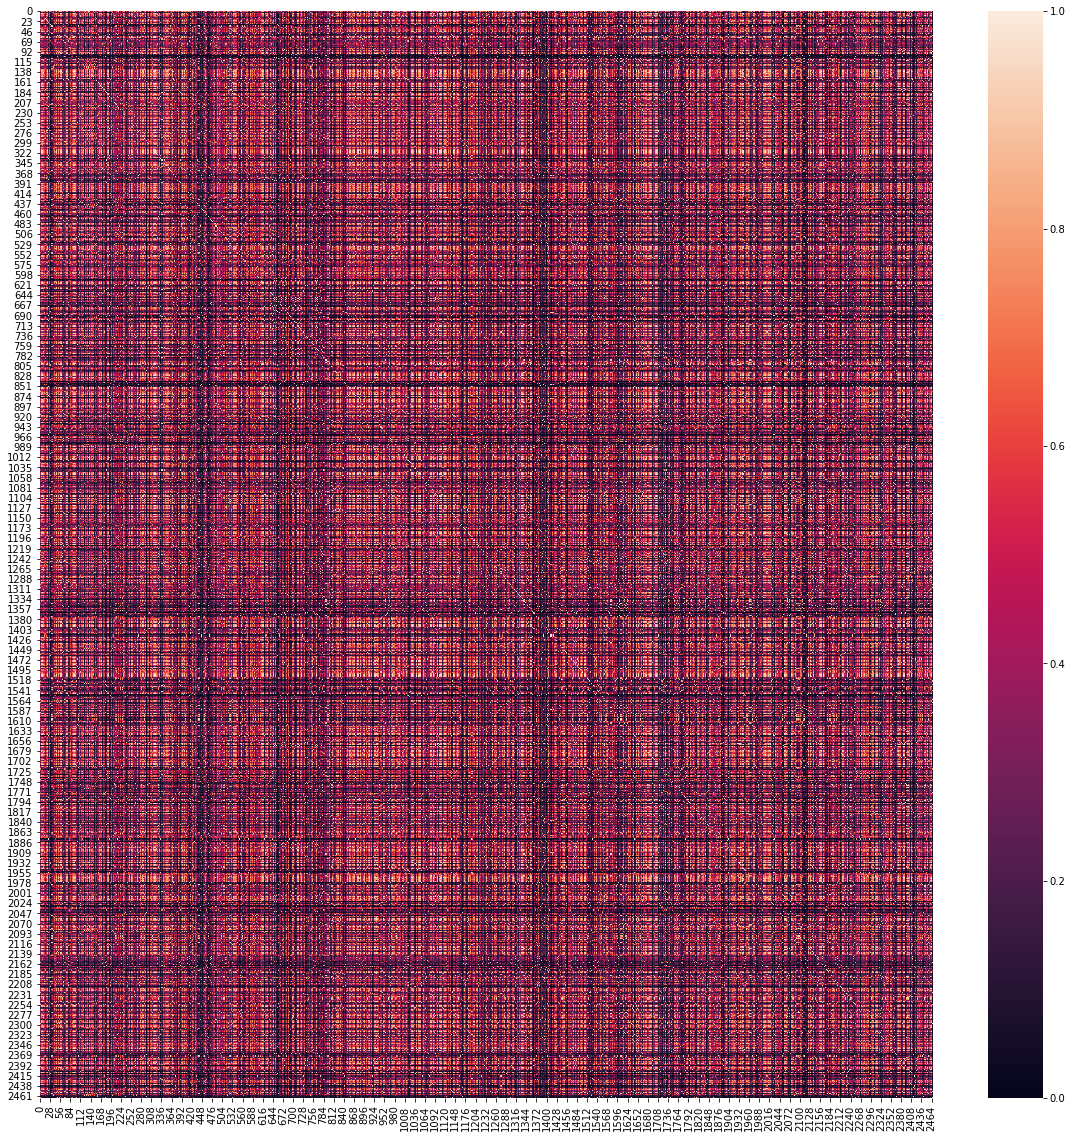

In [329]:
plt.figure(figsize = (20, 20))
sns.heatmap(pd.DataFrame(sim))

### to do
- add stop words, look at sklearn stop words 
- analysis of Brene Brown talk

### questions:

- followup: redistribution of topic0 - do topic modelling on documents that are topic0??????

- idelly topic distribution within corput
- topics over time
- other eda techniques to get a better grasp of topic data???


- help with lemmatizing, specifically men/women girl girls

- confused on min/max df ..... why does it cut off the features so drastically????? why do same words appear, just different counts

- error when trying to plot a hist of most values (now am also getting an error when convering the dict)

- lemmatise in a separate list and ppend to the df

In [162]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(nmf_topics_df, nmf_topics_df)